In [1]:
import pandas as pd
import json
import os
import datetime
import sys
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates  
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from hyperopt import space_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
#pip install hyperopt

In [3]:
import tqdm

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras.backend as K

In [5]:
#pip install --upgrade notebook

In [4]:
#pip install --upgrade ipywidgets

In [5]:
eggs_fulldata = [name for name in os.listdir('./dengue_eggs_2018_2024') if name.endswith('.csv')]
eggs_fulldata

['108.csv', '109.csv', '110.csv', '111.csv', '112.csv', '113.csv']

In [6]:
column_names = ["縣市別代碼", "行政區域代碼", "監測週期", "陽性率", "總卵粒數"]

df = {}

for file in eggs_fulldata:
    file_path = './dengue_eggs_2018_2024/' + file
    temp_df = pd.read_csv(file_path, names=column_names)
    temp_df = temp_df.iloc[1:]
    df[file[:-4]] = temp_df

In [7]:
dfs = []

for file in eggs_fulldata:
    file_path = './dengue_eggs_2018_2024/' + file
    temp_df = pd.read_csv(file_path, names=column_names)
    temp_df = temp_df.iloc[1:]
    dfs.append(temp_df)

merged_df = pd.concat(dfs, axis=0, ignore_index=True)

In [8]:
#把週期轉乘datetime

def convert_week_string_to_datetime(week_string):
    parts = week_string.split('年第')
    year = int(parts[0]) + 1911
    week_number = int(parts[1].rstrip('週'))
    start_of_year = datetime.datetime(year, 1, 1)
    date = start_of_year + datetime.timedelta(weeks=week_number - 1)
    return date

def convert_week_column_to_datetime(df, column_name):
    df[column_name] = df[column_name].apply(convert_week_string_to_datetime)

convert_week_column_to_datetime(merged_df, '監測週期')

In [9]:
sorted_df = merged_df.sort_values(by='監測週期')
sorted_df = sorted_df.drop_duplicates()

In [10]:
sorted_df = sorted_df.iloc[:,:]
sorted_df

,縣市別代碼,行政區域代碼,監測週期,陽性率,總卵粒數
0,67000,67000320,2019-06-04,53.89%,11243
1,67000,67000330,2019-06-04,50.23%,9318
2,67000,67000340,2019-06-04,54.80%,9535
3,67000,67000370,2019-06-04,55.83%,4497
4,67000,67000360,2019-06-04,51.28%,2776
...,...,...,...,...,...
2305,67000,67000350,2024-03-04,10.13%,1705
2306,67000,67000320,2024-03-04,3.15%,303
2307,67000,67000330,2024-03-04,6.98%,679
2309,67000,67000280,2024-03-04,7.14%,231


In [11]:
#sorted_df = sorted_df.drop(sorted_df.index[:240])

In [12]:
positive_rate = sorted_df['陽性率'].copy()
positive_rate = positive_rate.str.replace('%', '').astype(float)/100
sorted_df.insert(3, '陽性率%', positive_rate)

In [13]:
sorted_df = sorted_df.drop(columns=['陽性率'])

In [14]:
sorted_df = sorted_df.reset_index(drop=True)

In [15]:
sorted_df['總卵粒數'] =sorted_df['總卵粒數'].astype(float)

In [16]:
sorted_df

,縣市別代碼,行政區域代碼,監測週期,陽性率%,總卵粒數
0,67000,67000320,2019-06-04,0.5389,11243.0
1,67000,67000330,2019-06-04,0.5023,9318.0
2,67000,67000340,2019-06-04,0.5480,9535.0
3,67000,67000370,2019-06-04,0.5583,4497.0
4,67000,67000360,2019-06-04,0.5128,2776.0
...,...,...,...,...,...
2395,67000,67000350,2024-03-04,0.1013,1705.0
2396,67000,67000320,2024-03-04,0.0315,303.0
2397,67000,67000330,2024-03-04,0.0698,679.0
2398,67000,67000280,2024-03-04,0.0714,231.0


In [17]:
sorted_df = sorted_df.drop(sorted_df[(sorted_df['行政區域代碼'] == '67000010') | (sorted_df['行政區域代碼'] == '67000280')].index)    

In [18]:
sorted_df

,縣市別代碼,行政區域代碼,監測週期,陽性率%,總卵粒數
0,67000,67000320,2019-06-04,0.5389,11243.0
1,67000,67000330,2019-06-04,0.5023,9318.0
2,67000,67000340,2019-06-04,0.5480,9535.0
3,67000,67000370,2019-06-04,0.5583,4497.0
4,67000,67000360,2019-06-04,0.5128,2776.0
...,...,...,...,...,...
2393,67000,67000310,2024-03-04,0.0891,1149.0
2394,67000,67000360,2024-03-04,0.0321,200.0
2395,67000,67000350,2024-03-04,0.1013,1705.0
2396,67000,67000320,2024-03-04,0.0315,303.0


In [19]:
sorted_df['行政區域代碼'].unique()

array(['67000320', '67000330', '67000340', '67000370', '67000360',
       '67000350', '67000310', '67000270', '新營區', '南區', '東區', '安南區',
       '安平區', '永康區', '北區', '仁德區', '中西區', '歸仁區'], dtype=object)

In [20]:
sorted_df = sorted_df.drop(sorted_df[(sorted_df['行政區域代碼'] == '歸仁區') | (sorted_df['行政區域代碼'] == '新營區')].index)    

In [21]:
sorted_df['行政區域代碼'].unique()

array(['67000320', '67000330', '67000340', '67000370', '67000360',
       '67000350', '67000310', '67000270', '南區', '東區', '安南區', '安平區',
       '永康區', '北區', '仁德區', '中西區'], dtype=object)

In [22]:
sorted_df['行政區域代碼'] = sorted_df['行政區域代碼'].replace({ '南區':'67000330', '東區':'67000320', '安南區':'67000350','安平區': '67000360','永康區': '67000310', '北區': '67000340','仁德區': '67000270','中西區': '67000370'})
sorted_df['行政區域代碼'].unique()

array(['67000320', '67000330', '67000340', '67000370', '67000360',
       '67000350', '67000310', '67000270'], dtype=object)

In [23]:
# 8個區的資料筆數都是 246 筆
#count = (sorted_df['行政區域代碼'] == '67000270').sum()
#count

In [24]:
#sorted_df['行政區域代碼'] =sorted_df['行政區域代碼'].astype(float)

In [25]:
sorted_df = sorted_df.drop(columns=['縣市別代碼'])

In [26]:
sorted_df['行政區域代碼'].unique()

array(['67000320', '67000330', '67000340', '67000370', '67000360',
       '67000350', '67000310', '67000270'], dtype=object)

In [27]:
num_rows_sorted_df = sorted_df.shape[0]
num_rows_sorted_df #246*8 = 1968

1968

# 讀取天氣資料

In [28]:
folder_path = '8place_weather'

# 建立一個空的字典來存放各自的 DataFrame
dfs = {}

# 讀取資料夾中的每個檔案
for file_name in os.listdir(folder_path):
    # 檔案完整路徑
    file_path = os.path.join(folder_path, file_name)
    
    # 讀取 CSV 檔案並轉為 DataFrame
    df = pd.read_csv(file_path)
    
    df = df[['觀測時間(day)', '測站氣壓(hPa)', '氣溫(℃)', '最高氣溫(℃)', '最低氣溫(℃)', '相對溼度(%)', '降水量(mm)']]
    
    # 取得檔案名稱 (不含副檔名)
    df_name = os.path.splitext(file_name)[0]
    
    # 將 DataFrame 存入字典中，以檔案名稱為 key
    dfs[df_name] = df

# 印出各自的 DataFrame 名稱
print("讀取完畢的 DataFrame 名稱:")
print(list(dfs.keys()))

讀取完畢的 DataFrame 名稱:
['67000270', '67000310', '67000320', '67000330', '67000340', '67000350', '67000360', '67000370']


In [29]:
dfs  #8區歷年天氣資料 dataframe 

{'67000270':        觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  降水量(mm)
 0     2014-01-01     1015.4   17.6     25.0     12.0     71.0      0.0
 1     2014-01-02     1013.6   20.2     28.1     13.8     67.0      0.0
 2     2014-01-03     1011.5   21.9     27.3     18.5     71.0      0.0
 3     2014-01-04     1012.5   19.3     24.1     15.0     67.0      0.0
 4     2014-01-05     1014.7   17.1     23.1     12.8     64.0      0.0
 ...          ...        ...    ...      ...      ...      ...      ...
 3647  2023-12-27     1020.3   20.3     24.0     18.5     79.0      0.0
 3648  2023-12-28     1019.1   19.6     22.6     18.0     87.0      7.0
 3649  2023-12-29     1017.3   19.8     25.2     17.3     85.0      0.0
 3650  2023-12-30     1014.9   19.6     22.0     17.3     90.0      4.5
 3651  2023-12-31     1014.3   21.8     28.6     17.8     76.0      0.0
 
 [3652 rows x 7 columns],
 '67000310':        觀測時間(day)  測站氣壓(hPa)  氣溫(℃)  最高氣溫(℃)  最低氣溫(℃)  相對溼度(%)  降水量(mm)
 0     2014-

In [30]:
dfs['67000270']

,觀測時間(day),測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm)
0,2014-01-01,1015.4,17.6,25.0,12.0,71.0,0.0
1,2014-01-02,1013.6,20.2,28.1,13.8,67.0,0.0
2,2014-01-03,1011.5,21.9,27.3,18.5,71.0,0.0
3,2014-01-04,1012.5,19.3,24.1,15.0,67.0,0.0
4,2014-01-05,1014.7,17.1,23.1,12.8,64.0,0.0
...,...,...,...,...,...,...,...
3647,2023-12-27,1020.3,20.3,24.0,18.5,79.0,0.0
3648,2023-12-28,1019.1,19.6,22.6,18.0,87.0,7.0
3649,2023-12-29,1017.3,19.8,25.2,17.3,85.0,0.0
3650,2023-12-30,1014.9,19.6,22.0,17.3,90.0,4.5


# 合併 '8區' 和 '歷年天氣資料' 

In [31]:
sorted_df.dtypes

行政區域代碼            object
監測週期      datetime64[ns]
陽性率%             float64
總卵粒數             float64
dtype: object

In [32]:
sorted_df

,行政區域代碼,監測週期,陽性率%,總卵粒數
0,67000320,2019-06-04,0.5389,11243.0
1,67000330,2019-06-04,0.5023,9318.0
2,67000340,2019-06-04,0.5480,9535.0
3,67000370,2019-06-04,0.5583,4497.0
4,67000360,2019-06-04,0.5128,2776.0
...,...,...,...,...
2393,67000310,2024-03-04,0.0891,1149.0
2394,67000360,2024-03-04,0.0321,200.0
2395,67000350,2024-03-04,0.1013,1705.0
2396,67000320,2024-03-04,0.0315,303.0


# (合併 67000320)

In [33]:
df320 = sorted_df.copy()
df320_1 = df320[df320['行政區域代碼'] == '67000320'].copy()

df320_1['監測週期'] = pd.to_datetime(df320_1['監測週期'])
dfs['67000320']['觀測時間(day)'] = pd.to_datetime(dfs['67000320']['觀測時間(day)'])

merged_data_320 = pd.merge(df320_1, dfs['67000320'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_320 = merged_data_320.drop('觀測時間(day)', axis=1)
merged_data_320

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm)
0,67000320,2019-06-04,0.5389,11243.0,1007.3,27.8,30.6,25.2,77.0,19.5
1,67000320,2019-06-11,0.4630,8739.0,1003.1,26.7,28.6,25.2,85.0,114.0
2,67000320,2019-06-18,0.4611,6145.0,1007.5,31.2,34.6,28.1,66.0,0.0
3,67000320,2019-06-25,0.4611,7237.0,1005.7,28.1,31.0,25.0,75.0,15.5
4,67000320,2019-07-02,0.3852,5503.0,1001.9,28.1,30.5,25.9,81.0,19.5
...,...,...,...,...,...,...,...,...,...,...
231,67000320,2023-11-26,0.0722,1134.0,1015.4,22.2,27.3,19.4,73.0,0.0
232,67000320,2023-12-03,0.0778,1018.0,1016.2,21.3,24.9,18.9,77.0,0.0
233,67000320,2023-12-10,0.0722,728.0,1010.8,25.5,30.3,22.1,64.0,0.0
234,67000320,2023-12-17,0.0722,1074.0,1019.7,17.5,21.2,14.4,65.0,0.0


In [34]:
merged_data_320['總卵粒數-1'] = merged_data_320['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_320['總卵粒數-2'] = merged_data_320['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_320['總卵粒數-3'] = merged_data_320['總卵粒數'].shift(periods=3,fill_value=0)
merged_data_320

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
0,67000320,2019-06-04,0.5389,11243.0,1007.3,27.8,30.6,25.2,77.0,19.5,0.0,0.0,0.0
1,67000320,2019-06-11,0.4630,8739.0,1003.1,26.7,28.6,25.2,85.0,114.0,11243.0,0.0,0.0
2,67000320,2019-06-18,0.4611,6145.0,1007.5,31.2,34.6,28.1,66.0,0.0,8739.0,11243.0,0.0
3,67000320,2019-06-25,0.4611,7237.0,1005.7,28.1,31.0,25.0,75.0,15.5,6145.0,8739.0,11243.0
4,67000320,2019-07-02,0.3852,5503.0,1001.9,28.1,30.5,25.9,81.0,19.5,7237.0,6145.0,8739.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000320,2023-11-26,0.0722,1134.0,1015.4,22.2,27.3,19.4,73.0,0.0,1220.0,1336.0,2108.0
232,67000320,2023-12-03,0.0778,1018.0,1016.2,21.3,24.9,18.9,77.0,0.0,1134.0,1220.0,1336.0
233,67000320,2023-12-10,0.0722,728.0,1010.8,25.5,30.3,22.1,64.0,0.0,1018.0,1134.0,1220.0
234,67000320,2023-12-17,0.0722,1074.0,1019.7,17.5,21.2,14.4,65.0,0.0,728.0,1018.0,1134.0


In [35]:
merged_data_320 = merged_data_320.drop(merged_data_320.index[:3])
merged_data_320

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000320,2019-06-25,0.4611,7237.0,1005.7,28.1,31.0,25.0,75.0,15.5,6145.0,8739.0,11243.0
4,67000320,2019-07-02,0.3852,5503.0,1001.9,28.1,30.5,25.9,81.0,19.5,7237.0,6145.0,8739.0
5,67000320,2019-07-09,0.3111,4441.0,1003.6,27.6,29.6,25.6,84.0,61.0,5503.0,7237.0,6145.0
6,67000320,2019-07-16,0.4241,6124.0,1001.8,30.8,34.0,28.9,70.0,0.0,4441.0,5503.0,7237.0
7,67000320,2019-07-23,0.4019,5535.0,1004.7,29.4,32.9,27.1,72.0,0.0,6124.0,4441.0,5503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000320,2023-11-26,0.0722,1134.0,1015.4,22.2,27.3,19.4,73.0,0.0,1220.0,1336.0,2108.0
232,67000320,2023-12-03,0.0778,1018.0,1016.2,21.3,24.9,18.9,77.0,0.0,1134.0,1220.0,1336.0
233,67000320,2023-12-10,0.0722,728.0,1010.8,25.5,30.3,22.1,64.0,0.0,1018.0,1134.0,1220.0
234,67000320,2023-12-17,0.0722,1074.0,1019.7,17.5,21.2,14.4,65.0,0.0,728.0,1018.0,1134.0


# (合併 67000330)

In [36]:
df330 = sorted_df.copy()
df330_1 = df330[df330['行政區域代碼'] == '67000330'].copy()

df330_1['監測週期'] = pd.to_datetime(df330_1['監測週期'])
dfs['67000330']['觀測時間(day)'] = pd.to_datetime(dfs['67000330']['觀測時間(day)'])

merged_data_330 = pd.merge(df330_1, dfs['67000330'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_330 = merged_data_330.drop('觀測時間(day)', axis=1)

merged_data_330['總卵粒數-1'] = merged_data_330['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_330['總卵粒數-2'] = merged_data_330['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_330['總卵粒數-3'] = merged_data_330['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_330 = merged_data_330.drop(merged_data_330.index[:3])

merged_data_330 

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000330,2019-06-25,0.5203,9393.0,1006.4,28.0,31.5,24.8,87.0,10.0,6916.0,8377.0,9318.0
4,67000330,2019-07-02,0.4640,7016.0,1002.5,28.3,31.0,26.2,93.0,19.5,9393.0,6916.0,8377.0
5,67000330,2019-07-09,0.3941,5708.0,1004.3,27.5,30.2,26.0,99.0,51.0,7016.0,9393.0,6916.0
6,67000330,2019-07-16,0.4797,7184.0,1002.4,30.8,33.5,29.1,79.0,0.0,5708.0,7016.0,9393.0
7,67000330,2019-07-23,0.4797,7493.0,1005.5,29.1,31.7,26.3,84.0,0.0,7184.0,5708.0,7016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000330,2023-11-26,0.1577,1153.0,1016.8,23.2,27.7,20.4,74.0,0.0,1490.0,2295.0,3287.0
232,67000330,2023-12-03,0.1577,1219.0,1017.7,22.1,25.8,19.7,79.0,0.0,1153.0,1490.0,2295.0
233,67000330,2023-12-10,0.1689,1455.0,1012.1,26.5,30.5,23.2,67.0,0.0,1219.0,1153.0,1490.0
234,67000330,2023-12-17,0.1239,1240.0,1021.2,18.2,21.7,15.2,69.0,0.0,1455.0,1219.0,1153.0


# (合併 67000340)

In [37]:
df340 = sorted_df.copy()
df340_1 = df340[df340['行政區域代碼'] == '67000340'].copy()

df340_1['監測週期'] = pd.to_datetime(df340_1['監測週期'])
dfs['67000340']['觀測時間(day)'] = pd.to_datetime(dfs['67000340']['觀測時間(day)'])

merged_data_340 = pd.merge(df340_1, dfs['67000340'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_340 = merged_data_340.drop('觀測時間(day)', axis=1)

merged_data_340['總卵粒數-1'] = merged_data_340['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_340['總卵粒數-2'] = merged_data_340['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_340['總卵粒數-3'] = merged_data_340['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_340 = merged_data_340.drop(merged_data_340.index[:3])

merged_data_340

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000340,2019-06-25,0.5177,7416.0,1005.4,28.5,31.7,25.5,80.0,5.0,6045.0,7108.0,9535.0
4,67000340,2019-07-02,0.4369,5222.0,1001.4,28.6,30.7,26.3,90.0,18.0,7416.0,6045.0,7108.0
5,67000340,2019-07-09,0.3636,3437.0,1003.3,27.9,29.8,25.7,93.0,61.0,5222.0,7416.0,6045.0
6,67000340,2019-07-16,0.4571,6370.0,1001.6,30.6,32.8,28.8,79.0,0.0,3437.0,5222.0,7416.0
7,67000340,2019-07-23,0.4293,5246.0,1004.4,29.7,32.5,27.4,75.0,0.0,6370.0,3437.0,5222.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000340,2023-11-26,0.1111,863.0,1015.1,22.1,26.9,19.1,75.0,0.0,800.0,1810.0,2019.0
232,67000340,2023-12-03,0.0758,607.0,1015.9,21.5,25.1,18.9,78.0,0.0,863.0,800.0,1810.0
233,67000340,2023-12-10,0.0884,892.0,1010.5,25.3,30.1,22.0,66.0,0.0,607.0,863.0,800.0
234,67000340,2023-12-17,0.0682,694.0,1019.4,17.4,21.0,14.1,67.0,0.0,892.0,607.0,863.0


# (合併 67000270)

In [38]:
df270 = sorted_df.copy()
df270_1 = df270[df270['行政區域代碼'] == '67000270'].copy()

df270_1['監測週期'] = pd.to_datetime(df270_1['監測週期'])
dfs['67000270']['觀測時間(day)'] = pd.to_datetime(dfs['67000270']['觀測時間(day)'])

merged_data_270 = pd.merge(df270_1, dfs['67000270'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_270 = merged_data_270.drop('觀測時間(day)', axis=1)

merged_data_270['總卵粒數-1'] = merged_data_270['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_270['總卵粒數-2'] = merged_data_270['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_270['總卵粒數-3'] = merged_data_270['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_270 = merged_data_270.drop(merged_data_270.index[:3])

merged_data_270

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000270,2019-06-25,0.5208,3587.0,1005.7,27.7,31.5,24.0,84.0,29.5,2629.0,4265.0,4516.0
4,67000270,2019-07-02,0.4063,2972.0,1001.8,27.6,30.4,25.5,90.0,49.0,3587.0,2629.0,4265.0
5,67000270,2019-07-09,0.3646,1965.0,1003.6,27.1,29.4,25.8,92.0,53.0,2972.0,3587.0,2629.0
6,67000270,2019-07-16,0.4688,2963.0,1001.6,30.7,33.6,28.4,76.0,0.0,1965.0,2972.0,3587.0
7,67000270,2019-07-23,0.4427,2809.0,1004.6,28.7,32.3,25.3,81.0,0.0,2963.0,1965.0,2972.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000270,2023-11-26,0.1823,1070.0,1015.1,22.3,29.0,18.5,75.0,0.0,425.0,1072.0,1641.0
232,67000270,2023-12-03,0.1667,779.0,1016.0,21.7,25.1,18.7,77.0,0.0,1070.0,425.0,1072.0
233,67000270,2023-12-10,0.2083,1427.0,1010.9,25.5,30.5,21.5,68.0,0.0,779.0,1070.0,425.0
234,67000270,2023-12-17,0.1719,799.0,1019.9,17.7,22.0,14.5,71.0,0.0,1427.0,779.0,1070.0


# (合併 67000360)

In [39]:
df360 = sorted_df.copy()
df360_1 = df360[df360['行政區域代碼'] == '67000360'].copy()

df360_1['監測週期'] = pd.to_datetime(df360_1['監測週期'])
dfs['67000360']['觀測時間(day)'] = pd.to_datetime(dfs['67000360']['觀測時間(day)'])

merged_data_360 = pd.merge(df360_1, dfs['67000360'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_360 = merged_data_360.drop('觀測時間(day)', axis=1)

merged_data_360['總卵粒數-1'] = merged_data_360['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_360['總卵粒數-2'] = merged_data_360['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_360['總卵粒數-3'] = merged_data_360['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_360 = merged_data_360.drop(merged_data_360.index[:3])

merged_data_360

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000360,2019-06-25,0.5577,3553.0,1006.7,27.8,30.4,24.8,88.0,7.0,2783.0,2470.0,2776.0
4,67000360,2019-07-02,0.4231,2134.0,1002.7,28.2,30.2,26.0,94.0,19.0,3553.0,2783.0,2470.0
5,67000360,2019-07-09,0.4295,1783.0,1004.7,27.4,29.8,25.5,98.0,58.0,2134.0,3553.0,2783.0
6,67000360,2019-07-16,0.5064,2170.0,1002.8,30.2,33.1,28.5,85.0,0.0,1783.0,2134.0,3553.0
7,67000360,2019-07-23,0.5385,2794.0,1005.7,28.9,31.4,26.4,89.0,0.5,2170.0,1783.0,2134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000360,2023-11-26,0.1410,513.0,1016.7,21.6,26.3,18.5,79.0,0.0,500.0,893.0,940.0
232,67000360,2023-12-03,0.1859,835.0,1017.6,21.0,24.4,18.7,81.0,0.0,513.0,500.0,893.0
233,67000360,2023-12-10,0.1731,999.0,1012.1,24.6,29.0,21.7,72.0,0.0,835.0,513.0,500.0
234,67000360,2023-12-17,0.1346,661.0,1021.2,16.9,20.5,13.7,72.0,0.0,999.0,835.0,513.0


# (合併 67000350)

In [40]:
dfs['67000350']

,觀測時間(day),測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm)
0,2014-01-01,1018.9,16.6,24.0,11.3,77.0,0.0
1,2014-01-02,1017.1,18.8,26.6,12.7,79.0,0.0
2,2014-01-03,1014.8,21.6,26.7,17.8,74.0,0.0
3,2014-01-04,1016.0,19.2,24.0,14.3,69.0,0.0
4,2014-01-05,1018.2,16.5,22.7,12.0,69.0,0.0
...,...,...,...,...,...,...,...
3647,2023-12-27,1022.0,19.9,23.8,18.2,84.0,0.0
3648,2023-12-28,1020.8,19.1,20.7,17.9,91.0,9.0
3649,2023-12-29,1019.0,19.1,24.2,16.3,87.0,0.0
3650,2023-12-30,1016.4,19.4,23.2,16.8,89.0,0.0


In [41]:
df350 = sorted_df.copy()
df350_1 = df350[df350['行政區域代碼'] == '67000350'].copy()

df350_1['監測週期'] = pd.to_datetime(df350_1['監測週期'])
dfs['67000350']['觀測時間(day)'] = pd.to_datetime(dfs['67000350']['觀測時間(day)'])

merged_data_350 = pd.merge(df350_1, dfs['67000350'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_350 = merged_data_350.drop('觀測時間(day)', axis=1)

merged_data_350['總卵粒數-1'] = merged_data_350['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_350['總卵粒數-2'] = merged_data_350['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_350['總卵粒數-3'] = merged_data_350['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_350 = merged_data_350.drop(merged_data_350.index[:3])

merged_data_350

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000350,2019-06-25,0.6732,23324.0,1007.0,27.5,30.5,24.5,84.0,2.5,19167.0,18774.0,25018.0
4,67000350,2019-07-02,0.5768,15617.0,1002.9,28.5,31.5,26.1,85.0,18.5,23324.0,19167.0,18774.0
5,67000350,2019-07-09,0.4575,8758.0,1004.7,27.4,30.2,25.5,91.0,69.0,15617.0,23324.0,19167.0
6,67000350,2019-07-16,0.5507,12850.0,1003.2,30.1,33.2,28.2,80.0,0.0,8758.0,15617.0,23324.0
7,67000350,2019-07-23,0.5539,13634.0,1006.0,28.7,31.8,25.1,84.0,3.5,12850.0,8758.0,15617.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000350,2023-11-26,0.1585,2319.0,1017.4,21.0,24.5,18.1,92.0,0.0,3128.0,3779.0,4433.0
232,67000350,2023-12-03,0.1471,2314.0,1017.3,20.9,23.4,19.0,84.0,0.0,2319.0,3128.0,3779.0
233,67000350,2023-12-10,0.1552,2148.0,1011.8,24.0,26.5,21.7,78.0,0.0,2314.0,2319.0,3128.0
234,67000350,2023-12-17,0.1242,2171.0,1020.9,16.3,19.2,13.3,75.0,0.0,2148.0,2314.0,2319.0


# (合併 67000310)

In [71]:
df310 = sorted_df.copy()
df310_1 = df310[df310['行政區域代碼'] == '67000310'].copy()

df310_1['監測週期'] = pd.to_datetime(df310_1['監測週期'])
dfs['67000310']['觀測時間(day)'] = pd.to_datetime(dfs['67000310']['觀測時間(day)'])

merged_data_310 = pd.merge(df310_1, dfs['67000310'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_310 = merged_data_310.drop('觀測時間(day)', axis=1)

merged_data_310['總卵粒數-1'] = merged_data_310['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_310['總卵粒數-2'] = merged_data_310['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_310['總卵粒數-3'] = merged_data_310['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_310 = merged_data_310.drop(merged_data_310.index[:3])

merged_data_310

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000310,2019-06-25,0.6260,14728.0,1007.0,27.6,30.5,24.7,79.0,7.5,13832.0,15830.0,19584.0
4,67000310,2019-07-02,0.5736,10642.0,1003.0,27.6,30.4,25.4,85.0,35.0,14728.0,13832.0,15830.0
5,67000310,2019-07-09,0.5310,10241.0,1004.7,27.1,28.9,25.3,86.0,48.5,10642.0,14728.0,13832.0
6,67000310,2019-07-16,0.6415,11804.0,1003.0,30.3,33.5,28.2,79.0,0.0,10241.0,10642.0,14728.0
7,67000310,2019-07-23,0.5833,11184.0,1006.0,29.3,33.2,26.1,78.0,0.0,11804.0,10241.0,10642.0
8,67000310,2019-07-30,0.5078,9389.0,1005.7,29.7,34.9,26.7,75.0,0.5,11184.0,11804.0,10241.0
9,67000310,2019-08-06,0.5252,10958.0,1000.1,29.0,34.3,26.7,77.0,21.0,9389.0,11184.0,11804.0
10,67000310,2019-08-13,0.5252,9145.0,1001.6,26.1,29.5,24.1,85.0,280.0,10958.0,9389.0,11184.0
11,67000310,2019-08-20,0.4244,5469.0,1003.8,26.4,30.2,24.9,83.0,1.0,9145.0,10958.0,9389.0
12,67000310,2019-08-27,0.5213,8312.0,1006.9,29.5,35.7,25.3,75.8,0.0,5469.0,9145.0,10958.0


# (合併 67000370)

In [43]:
df370 = sorted_df.copy()
df370_1 = df370[df370['行政區域代碼'] == '67000370'].copy()

df370_1['監測週期'] = pd.to_datetime(df370_1['監測週期'])
dfs['67000370']['觀測時間(day)'] = pd.to_datetime(dfs['67000370']['觀測時間(day)'])

merged_data_370 = pd.merge(df370_1, dfs['67000370'], left_on='監測週期', right_on='觀測時間(day)', how='inner')
merged_data_370 = merged_data_370.drop('觀測時間(day)', axis=1)

merged_data_370['總卵粒數-1'] = merged_data_370['總卵粒數'].shift(periods=1,fill_value=0)
merged_data_370['總卵粒數-2'] = merged_data_370['總卵粒數'].shift(periods=2,fill_value=0)
merged_data_370['總卵粒數-3'] = merged_data_370['總卵粒數'].shift(periods=3,fill_value=0)

merged_data_370 = merged_data_370.drop(merged_data_370.index[:3])

merged_data_370

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
3,67000370,2019-06-25,0.5417,4961.0,1005.7,28.1,31.0,25.0,75.0,15.5,3632.0,4350.0,4497.0
4,67000370,2019-07-02,0.5125,3747.0,1001.9,28.1,30.5,25.9,81.0,19.5,4961.0,3632.0,4350.0
5,67000370,2019-07-09,0.3833,1854.0,1003.6,27.6,29.6,25.6,84.0,61.0,3747.0,4961.0,3632.0
6,67000370,2019-07-16,0.4583,2560.0,1001.8,30.8,34.0,28.9,70.0,0.0,1854.0,3747.0,4961.0
7,67000370,2019-07-23,0.4625,3687.0,1004.7,29.4,32.9,27.1,72.0,0.0,2560.0,1854.0,3747.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,67000370,2023-11-26,0.1417,745.0,1015.4,22.2,27.3,19.4,73.0,0.0,1257.0,1506.0,1663.0
232,67000370,2023-12-03,0.1208,716.0,1016.2,21.3,24.9,18.9,77.0,0.0,745.0,1257.0,1506.0
233,67000370,2023-12-10,0.1292,934.0,1010.8,25.5,30.3,22.1,64.0,0.0,716.0,745.0,1257.0
234,67000370,2023-12-17,0.1208,893.0,1019.7,17.5,21.2,14.4,65.0,0.0,934.0,716.0,745.0


# -----合併結束-----

In [44]:
#永康區
selected_data = sorted_df[sorted_df['行政區域代碼'] == 67000310].copy()
selected_data

,行政區域代碼,監測週期,陽性率%,總卵粒數


In [18]:
young_df = selected_data.copy()

In [19]:
young_df['總卵粒數1'] = young_df['總卵粒數'].shift(periods=1,fill_value=0)
young_df['總卵粒數2'] = young_df['總卵粒數'].shift(periods=2,fill_value=0)
young_df['總卵粒數3'] = young_df['總卵粒數'].shift(periods=3,fill_value=0)

num_rows_selected_data = selected_data.shape[0]
num_rows_selected_data

216

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\634149008.py:13: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\634149008.py:13: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  plt.tight_layout()
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lilj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


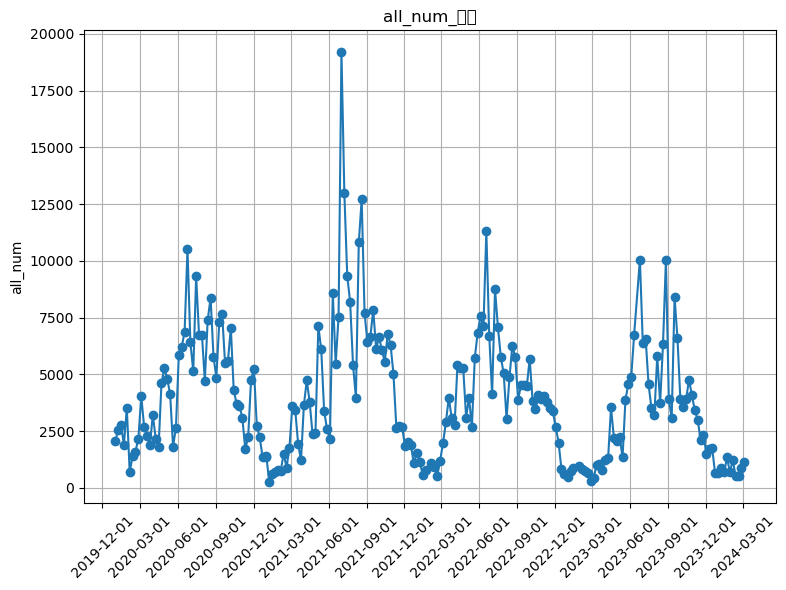

In [20]:
plt.figure(figsize=(8, 6))

plt.plot(selected_data['監測週期'], selected_data['總卵粒數'], marker='o', linestyle='-')

plt.ylabel('all_num')
plt.title('all_num_永康')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_5032\1344515532.py:15: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  plt.tight_layout()
C:\Users\jonat\AppData\Local\Temp\ipykernel_5032\1344515532.py:15: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  plt.tight_layout()
C:\Users\jonat\anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jonat\anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


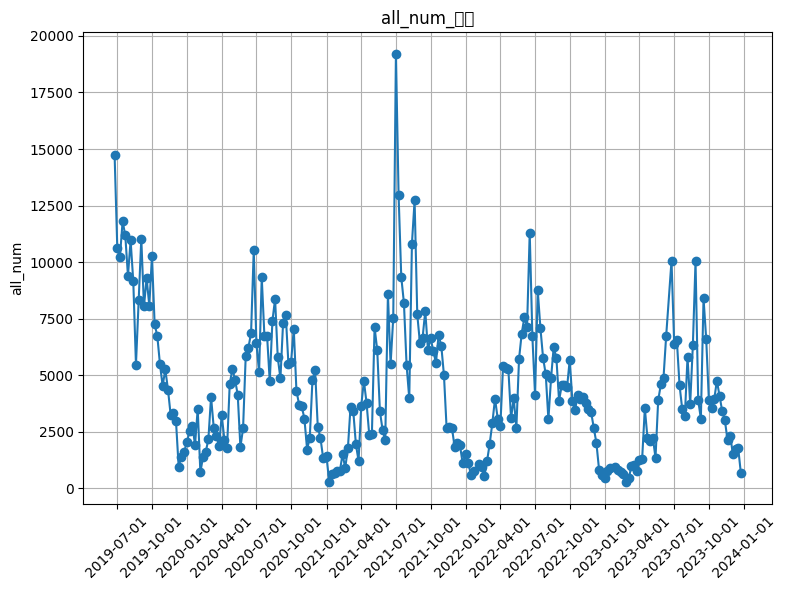

In [213]:
#merged_data_310

plt.figure(figsize=(8, 6))

plt.plot(merged_data_310['監測週期'], merged_data_310['總卵粒數'], marker='o', linestyle='-')

plt.ylabel('all_num')
plt.title('all_num_永康')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 讀取天氣資料

In [21]:
weather = pd.read_csv('young_kang_2018-2024_weather_.csv')

In [22]:
weather['觀測時間(day)'] = pd.to_datetime(weather['觀測時間(day)'])
selected_data['監測週期'] = pd.to_datetime(selected_data['監測週期'])

In [23]:
sorted_df['監測週期'] = pd.to_datetime(sorted_df['監測週期'])

In [24]:
young_df_weather =  pd.merge(weather, young_df, left_on='觀測時間(day)', right_on='監測週期', how='inner')

In [25]:
young_df_weather

,觀測時間(day),測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),...,最大六十分鐘降水量(mm),日照時數(hour),日照率(%),行政區域代碼,監測週期,陽性率%,總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3
0,2020-01-01,1023.3,17.8,22.8,14.9,76.0,2.6,360,7.7,330.0,...,0.0,5.1,47.6,67000310.0,2020-01-01,0.1182,2060.0,0.0,0.0,0.0
1,2020-01-08,1016.6,20.0,25.8,16.4,74.0,2.9,350,8.3,10.0,...,0.0,9.6,89.3,67000310.0,2020-01-08,0.1570,2543.0,2060.0,0.0,0.0
2,2020-01-15,1017.1,18.2,25.8,14.0,76.0,2.9,350,8.9,340.0,...,0.0,8.7,80.4,67000310.0,2020-01-15,0.1628,2775.0,2543.0,2060.0,0.0
3,2020-01-22,1017.8,21.7,28.2,16.8,70.0,1.9,360,9.6,350.0,...,0.0,6.8,62.4,67000310.0,2020-01-22,0.1105,1910.0,2775.0,2543.0,2060.0
4,2020-01-29,1016.5,14.3,18.8,11.9,67.0,5.4,360,11.6,360.0,...,0.0,3.6,32.7,67000310.0,2020-01-29,0.1550,3513.0,1910.0,2775.0,2543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2024-02-05,1017.1,20.8,27.2,17.5,82.0,3.8,360,12.1,360.0,...,0.0,2.3,20.6,67000310.0,2024-02-05,0.0969,1217.0,693.0,1339.0,677.0
212,2024-02-12,1024.8,17.3,23.9,12.8,67.0,2.2,360,8.4,320.0,...,0.0,10.5,93.1,67000310.0,2024-02-12,0.0426,522.0,1217.0,693.0,1339.0
213,2024-02-19,1015.2,25.5,31.3,21.0,72.0,2.7,250,8.1,280.0,...,0.0,8.9,77.9,67000310.0,2024-02-19,0.0446,539.0,522.0,1217.0,693.0
214,2024-02-26,1019.5,17.6,23.8,14.4,69.0,3.7,360,11.3,350.0,...,0.0,3.0,25.9,67000310.0,2024-02-26,0.0620,885.0,539.0,522.0,1217.0


In [26]:
young_df_weather = young_df_weather.drop(columns=['行政區域代碼','監測週期'])

column_orders = [0,17,18,19,20,16,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15]
young_df_weather = young_df_weather.iloc[:, column_orders]

young_df_weather = young_df_weather.iloc[3:,:]

#young_df_weather 可以拿來用了

# 0506_LSTM

In [65]:
#merged_data_310.reset_index(drop=True, inplace=True)

In [78]:
merged_data_310.reset_index(drop=True, inplace=True)
merged_data_310

,行政區域代碼,監測週期,陽性率%,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
0,67000310,2019-06-25,0.6260,14728.0,1007.0,27.6,30.5,24.7,79.0,7.5,13832.0,15830.0,19584.0
1,67000310,2019-07-02,0.5736,10642.0,1003.0,27.6,30.4,25.4,85.0,35.0,14728.0,13832.0,15830.0
2,67000310,2019-07-09,0.5310,10241.0,1004.7,27.1,28.9,25.3,86.0,48.5,10642.0,14728.0,13832.0
3,67000310,2019-07-16,0.6415,11804.0,1003.0,30.3,33.5,28.2,79.0,0.0,10241.0,10642.0,14728.0
4,67000310,2019-07-23,0.5833,11184.0,1006.0,29.3,33.2,26.1,78.0,0.0,11804.0,10241.0,10642.0
5,67000310,2019-07-30,0.5078,9389.0,1005.7,29.7,34.9,26.7,75.0,0.5,11184.0,11804.0,10241.0
6,67000310,2019-08-06,0.5252,10958.0,1000.1,29.0,34.3,26.7,77.0,21.0,9389.0,11184.0,11804.0
7,67000310,2019-08-13,0.5252,9145.0,1001.6,26.1,29.5,24.1,85.0,280.0,10958.0,9389.0,11184.0
8,67000310,2019-08-20,0.4244,5469.0,1003.8,26.4,30.2,24.9,83.0,1.0,9145.0,10958.0,9389.0
9,67000310,2019-08-27,0.5213,8312.0,1006.9,29.5,35.7,25.3,75.8,0.0,5469.0,9145.0,10958.0


In [79]:
#永康
df = merged_data_310.copy()
df.set_index(['監測週期'], inplace=True)
df = df.drop(columns=['行政區域代碼', '陽性率%'])

In [80]:
# 設置顯示的最大行和列數
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [81]:
df

,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
監測週期,,,,,,,,,,
2019-06-25,14728.0,1007.0,27.6,30.5,24.7,79.0,7.5,13832.0,15830.0,19584.0
2019-07-02,10642.0,1003.0,27.6,30.4,25.4,85.0,35.0,14728.0,13832.0,15830.0
2019-07-09,10241.0,1004.7,27.1,28.9,25.3,86.0,48.5,10642.0,14728.0,13832.0
2019-07-16,11804.0,1003.0,30.3,33.5,28.2,79.0,0.0,10241.0,10642.0,14728.0
2019-07-23,11184.0,1006.0,29.3,33.2,26.1,78.0,0.0,11804.0,10241.0,10642.0
2019-07-30,9389.0,1005.7,29.7,34.9,26.7,75.0,0.5,11184.0,11804.0,10241.0
2019-08-06,10958.0,1000.1,29.0,34.3,26.7,77.0,21.0,9389.0,11184.0,11804.0
2019-08-13,9145.0,1001.6,26.1,29.5,24.1,85.0,280.0,10958.0,9389.0,11184.0
2019-08-20,5469.0,1003.8,26.4,30.2,24.9,83.0,1.0,9145.0,10958.0,9389.0


In [82]:
train = df[0:183]
test = df[183:]

In [83]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [84]:
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\jonat\AppData\Local\Temp\ipykernel_21788\567902423.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/180 [00:00<?, ?it/s]

In [85]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(180, 3, 9)
(180,)


In [86]:
n_steps = 3
#n_features = 15
n_features = 9
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [87]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 8ms/step - loss: 0.0532 - mse: 0.0532 - mape: 346083.8438
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0421 - mse: 0.0421 - mape: 520945.6875
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0331 - mse: 0.0331 - mape: 575382.0000
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0256 - mse: 0.0256 - mape: 732833.5625
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0210 - mse: 0.0210 - mape: 831298.2500
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0185 - mse: 0.0185 - mape: 917400.8750
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0177 - mse: 0.0177 - mape: 982777.6250
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0181 - mse: 0.0181 - mape: 1022460.0625
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0184 - mse: 0.0184 - mape: 102

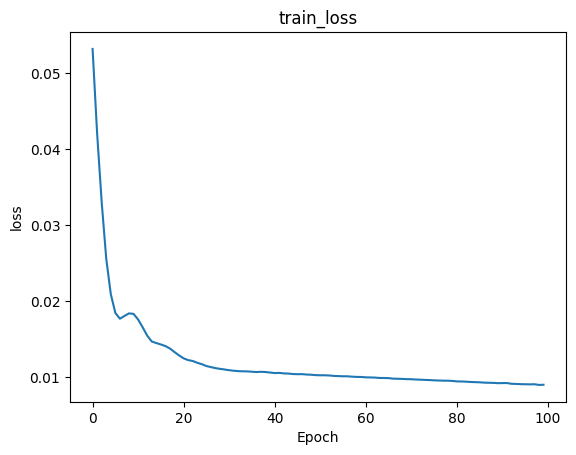

In [88]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [93]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [94]:
predicted_values.shape

(47, 1)

In [95]:
predicted_values = np.repeat(predicted_values, 10, axis=1)  #10 = feature+1

In [96]:
predicted_values = scaler.inverse_transform(predicted_values)
predicted_values

array([[1.28284790e+03, 9.95432678e+02, 1.53776360e+01, 2.22098503e+01,
        1.05636930e+01, 6.53713837e+01, 4.75058079e+00, 1.28284790e+03,
        1.28284790e+03, 1.28284790e+03],
       [7.23425598e+02, 9.93510132e+02, 1.43820400e+01, 2.14202385e+01,
        9.40788555e+00, 6.34831810e+01, 2.08993459e+00, 7.23425598e+02,
        7.23425598e+02, 7.23425598e+02],
       [9.94402100e+02, 9.94441406e+02, 1.48642931e+01, 2.18027153e+01,
        9.96774292e+00, 6.43977966e+01, 3.37871528e+00, 9.94402100e+02,
        9.94402100e+02, 9.94402100e+02],
       [1.19747583e+03, 9.95139282e+02, 1.52257013e+01, 2.20893497e+01,
        1.03873081e+01, 6.50832291e+01, 4.34454584e+00, 1.19747583e+03,
        1.19747583e+03, 1.19747583e+03],
       [1.26537585e+03, 9.95372620e+02, 1.53465424e+01, 2.21851883e+01,
        1.05275946e+01, 6.53124084e+01, 4.66748238e+00, 1.26537585e+03,
        1.26537585e+03, 1.26537585e+03],
       [9.84055847e+02, 9.94405823e+02, 1.48458805e+01, 2.17881126e+01,
   

In [97]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
new_df

,預測出的卵粒數
0,1282.847900
1,723.425598
2,994.402100
3,1197.475830
4,1265.375854
5,984.055847
6,719.301880
7,769.683228
8,961.985901
9,1257.354980


In [98]:
look_df = df.copy()
last_85_rows = look_df.iloc[-47:]
last_85_rows.shape

(47, 10)

In [99]:
last_85_rows

,總卵粒數,測站氣壓(hPa),氣溫(℃),最高氣溫(℃),最低氣溫(℃),相對溼度(%),降水量(mm),總卵粒數-1,總卵粒數-2,總卵粒數-3
監測週期,,,,,,,,,,
2023-01-29,948.0,1020.0,13.6,20.8,8.5,66.0,0.0,893.0,756.0,470.0
2023-02-05,815.0,1014.4,19.4,26.6,17.0,85.0,0.0,948.0,893.0,756.0
2023-02-12,728.0,1013.3,23.8,29.8,18.6,79.0,0.0,815.0,948.0,893.0
2023-02-19,634.0,1015.1,19.5,27.7,15.3,81.0,0.0,728.0,815.0,948.0
2023-02-26,284.0,1025.6,16.0,21.5,13.2,62.0,0.0,634.0,728.0,815.0
2023-03-05,440.0,1020.7,18.8,26.7,13.4,67.0,0.0,284.0,634.0,728.0
2023-03-12,1004.0,1016.6,22.1,28.0,18.1,69.0,0.0,440.0,284.0,634.0
2023-03-19,1041.0,1013.8,22.2,27.8,18.2,76.0,0.0,1004.0,440.0,284.0
2023-03-26,779.0,1012.8,21.5,27.0,18.0,82.0,0.5,1041.0,1004.0,440.0


In [100]:
df_85_ = merged_data_310.copy()
df_85_ = df_85_[-47:]
df_85_ = df_85_[['監測週期','總卵粒數']]
df_85_reset_index = df_85_.reset_index(drop=True)

df_85_reset_index

,監測週期,總卵粒數
0,2023-01-29,948.0
1,2023-02-05,815.0
2,2023-02-12,728.0
3,2023-02-19,634.0
4,2023-02-26,284.0
5,2023-03-05,440.0
6,2023-03-12,1004.0
7,2023-03-19,1041.0
8,2023-03-26,779.0
9,2023-04-02,1228.0


In [101]:
new_df = new_df.astype('float64')
new_df

,預測出的卵粒數
0,1282.847900
1,723.425598
2,994.402100
3,1197.475830
4,1265.375854
5,984.055847
6,719.301880
7,769.683228
8,961.985901
9,1257.354980


In [102]:
merged_df = pd.concat([df_85_reset_index, new_df], axis=1)
merged_df

,監測週期,總卵粒數,預測出的卵粒數
0,2023-01-29,948.0,1282.847900
1,2023-02-05,815.0,723.425598
2,2023-02-12,728.0,994.402100
3,2023-02-19,634.0,1197.475830
4,2023-02-26,284.0,1265.375854
5,2023-03-05,440.0,984.055847
6,2023-03-12,1004.0,719.301880
7,2023-03-19,1041.0,769.683228
8,2023-03-26,779.0,961.985901
9,2023-04-02,1228.0,1257.354980


In [103]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1691.5512929784263


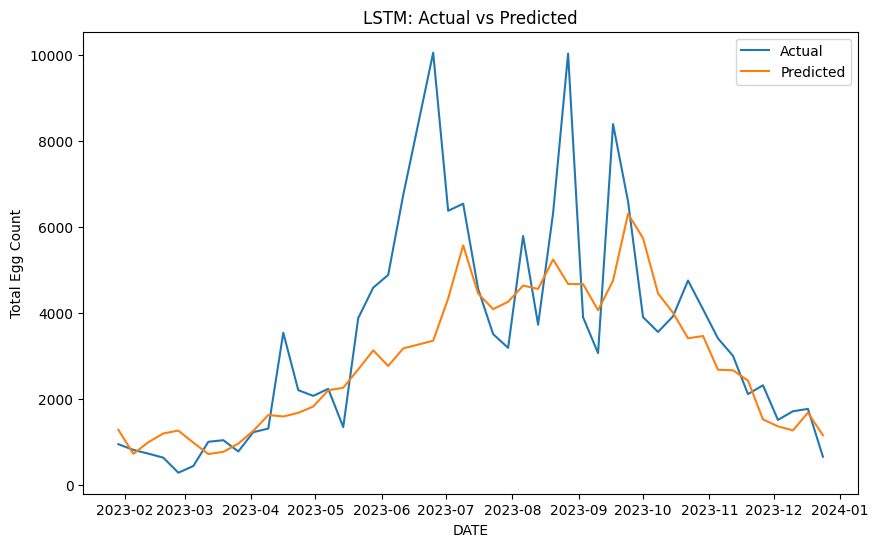

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['監測週期'], merged_df['總卵粒數'], label='Actual')
plt.plot(merged_df['監測週期'], merged_df['預測出的卵粒數'], label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()

# LSTM

In [79]:
# 設置顯示的最大行和列數
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [144]:
young_df_weather

,觀測時間(day),總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
3,2020-01-22,1910.0,2775.0,2543.0,2060.0,0.1105,21.7,1017.8,28.2,16.8,70.0,1.9,360,9.6,350.0,0.0,0.0,0.0,0.0,6.8,62.4
4,2020-01-29,3513.0,1910.0,2775.0,2543.0,0.1550,14.3,1016.5,18.8,11.9,67.0,5.4,360,11.6,360.0,0.0,0.0,0.0,0.0,3.6,32.7
5,2020-02-05,701.0,3513.0,1910.0,2775.0,0.0523,18.3,1018.0,25.1,14.4,73.0,4.0,360,9.0,360.0,0.0,0.0,0.0,0.0,9.2,82.7
6,2020-02-12,1398.0,701.0,3513.0,1910.0,0.0853,0.0,1016.5,0.0,0.0,0.0,2.2,200,12.4,210.0,0.0,0.0,0.0,0.0,9.3,82.6
7,2020-02-19,1598.0,1398.0,701.0,3513.0,0.1085,0.0,1022.6,0.0,0.0,0.0,2.6,350,8.1,350.0,0.0,0.0,0.0,0.0,10.0,87.7
8,2020-02-26,2171.0,1598.0,1398.0,701.0,0.1202,24.1,1016.1,29.7,20.0,73.0,2.7,360,9.6,330.0,0.0,0.0,0.0,0.0,10.7,92.7
9,2020-03-04,4046.0,2171.0,1598.0,1398.0,0.1957,21.9,1015.4,27.0,16.7,73.0,4.4,360,12.3,360.0,0.0,0.1,0.0,0.0,2.6,22.3
10,2020-03-11,2684.0,4046.0,2171.0,1598.0,0.1550,20.3,1016.2,25.9,16.4,63.0,3.0,360,8.8,10.0,0.0,0.0,0.0,0.0,2.8,23.7
11,2020-03-18,2301.0,2684.0,4046.0,2171.0,0.1376,22.2,1014.4,26.7,18.9,70.0,1.7,130,6.5,320.0,0.0,0.0,0.0,0.0,2.8,23.4
12,2020-03-25,1869.0,2301.0,2684.0,4046.0,0.1240,24.9,1012.5,30.3,21.6,77.0,2.4,10,7.3,320.0,0.0,0.0,0.0,0.0,7.2,59.3


In [400]:
df = young_df_weather.copy()

In [401]:
df.set_index(['觀測時間(day)'], inplace=True)

#df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3', '陽性率%'])
df = df.drop(columns=['陽性率%'])

In [402]:
df

,總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
觀測時間(day),,,,,,,,,,,,,,,,,,,
2020-01-22,1910.0,2775.0,2543.0,2060.0,21.7,1017.8,28.2,16.8,70.0,1.9,360,9.6,350.0,0.0,0.0,0.0,0.0,6.8,62.4
2020-01-29,3513.0,1910.0,2775.0,2543.0,14.3,1016.5,18.8,11.9,67.0,5.4,360,11.6,360.0,0.0,0.0,0.0,0.0,3.6,32.7
2020-02-05,701.0,3513.0,1910.0,2775.0,18.3,1018.0,25.1,14.4,73.0,4.0,360,9.0,360.0,0.0,0.0,0.0,0.0,9.2,82.7
2020-02-12,1398.0,701.0,3513.0,1910.0,0.0,1016.5,0.0,0.0,0.0,2.2,200,12.4,210.0,0.0,0.0,0.0,0.0,9.3,82.6
2020-02-19,1598.0,1398.0,701.0,3513.0,0.0,1022.6,0.0,0.0,0.0,2.6,350,8.1,350.0,0.0,0.0,0.0,0.0,10.0,87.7
2020-02-26,2171.0,1598.0,1398.0,701.0,24.1,1016.1,29.7,20.0,73.0,2.7,360,9.6,330.0,0.0,0.0,0.0,0.0,10.7,92.7
2020-03-04,4046.0,2171.0,1598.0,1398.0,21.9,1015.4,27.0,16.7,73.0,4.4,360,12.3,360.0,0.0,0.1,0.0,0.0,2.6,22.3
2020-03-11,2684.0,4046.0,2171.0,1598.0,20.3,1016.2,25.9,16.4,63.0,3.0,360,8.8,10.0,0.0,0.0,0.0,0.0,2.8,23.7
2020-03-18,2301.0,2684.0,4046.0,2171.0,22.2,1014.4,26.7,18.9,70.0,1.7,130,6.5,320.0,0.0,0.0,0.0,0.0,2.8,23.4


In [403]:
train = df[0:120]
test = df[120:]

In [404]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [405]:
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\567902423.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/117 [00:00<?, ?it/s]

In [406]:
print(X[0])
print(y[0])

[[0.1323444  0.12009713 0.09459959 0.7        0.83728814 0.8034188
  0.59574468 0.72916667 0.0877193  1.         0.48241206 0.97222222
  0.         0.         0.         0.         0.57627119 0.66312434]
 [0.0866811  0.1323444  0.12009713 0.46129032 0.79322034 0.53561254
  0.42198582 0.69791667 0.70175439 1.         0.58291457 1.
  0.         0.         0.         0.         0.30508475 0.34750266]
 [0.17130338 0.0866811  0.1323444  0.59032258 0.8440678  0.71509972
  0.5106383  0.76041667 0.45614035 1.         0.45226131 1.
  0.         0.         0.         0.         0.77966102 0.87885228]]
0.05965264213693713


In [407]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(117, 3, 18)
(117,)


In [408]:
n_steps = 3
#n_features = 15
n_features = 18
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [409]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 3ms/step - loss: 0.0648 - mse: 0.0648 - mape: 34169.8398
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0369 - mse: 0.0369 - mape: 694847.0000
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0229 - mse: 0.0229 - mape: 989087.9375
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 0.0224 - mape: 1504767.3750
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257 - mape: 1817172.6250
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0270 - mse: 0.0270 - mape: 1881289.1250
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0250 - mse: 0.0250 - mape: 1771027.3750
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0214 - mse: 0.0214 - mape: 1563466.7500
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0185 - mse: 0.0185 - mape: 

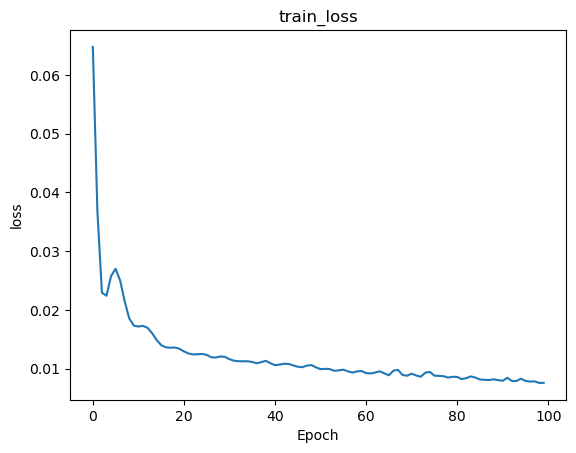

In [410]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

轉回正常值

In [415]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [416]:
predicted_values

array([[ 0.27885985],
       [ 0.30543244],
       [ 0.29512465],
       [ 0.37794158],
       [ 0.34232157],
       [ 0.30784094],
       [ 0.41693687],
       [ 0.36993593],
       [ 0.3388859 ],
       [ 0.3152958 ],
       [ 0.3271032 ],
       [ 0.30464268],
       [ 0.2674197 ],
       [ 0.32355562],
       [ 0.36437216],
       [ 0.35677975],
       [ 0.34385487],
       [ 0.24959214],
       [ 0.25564632],
       [ 0.25518796],
       [ 0.25036559],
       [ 0.2090026 ],
       [ 0.2133138 ],
       [ 0.1421269 ],
       [ 0.15991038],
       [ 0.17058745],
       [ 0.12909783],
       [ 0.13933286],
       [ 0.08212861],
       [ 0.03147018],
       [ 0.06936932],
       [ 0.05925729],
       [ 0.06629015],
       [ 0.01442228],
       [ 0.04041854],
       [ 0.03216297],
       [ 0.07587459],
       [ 0.02961802],
       [ 0.02584409],
       [ 0.08660613],
       [ 0.1655785 ],
       [ 0.15888284],
       [ 0.06400114],
       [ 0.08158293],
       [ 0.11395764],
       [ 0

In [417]:
predicted_values.shape

(90, 1)

In [418]:
predicted_values = np.repeat(predicted_values, 19, axis=1)

In [419]:
predicted_values.shape

(90, 19)

In [420]:
predicted_values = scaler.inverse_transform(predicted_values)

In [421]:
predicted_values

array([[3.3564778e+03, 3.3564778e+03, 3.3564778e+03, ..., 1.0596674e+01,
        3.3463182e+00, 2.6240713e+01],
       [3.6492546e+03, 3.6492546e+03, 3.6492546e+03, ..., 1.1606433e+01,
        3.6651893e+00, 2.8741192e+01],
       [3.5356833e+03, 3.5356833e+03, 3.5356833e+03, ..., 1.1214737e+01,
        3.5414958e+00, 2.7771229e+01],
       ...,
       [8.8050732e+02, 8.8050732e+02, 8.8050732e+02, ..., 2.0572953e+00,
        6.4967221e-01, 5.0945129e+00],
       [1.5445779e+03, 1.5445779e+03, 1.5445779e+03, ..., 4.3476090e+00,
        1.3729292e+00, 1.0766053e+01],
       [1.1853998e+03, 1.1853998e+03, 1.1853998e+03, ..., 3.1088393e+00,
        9.8173875e-01, 7.6984682e+00]], dtype=float32)

In [422]:
P_d = predicted_values.copy()

In [423]:
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])

In [424]:
new_df

,預測出的卵粒數
0,3356.477783
1,3649.254639
2,3535.683350
3,4448.160156
4,4055.698975
5,3675.791504
6,4877.810547
7,4359.954102
8,4017.844727
9,3757.928955


In [425]:
look_df = df.copy()

In [426]:
last_85_rows = look_df.iloc[-90:]
last_85_rows.shape

(90, 19)

In [427]:
last_85_rows

,總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
觀測時間(day),,,,,,,,,,,,,,,,,,,
2022-06-04,7569.0,6842.0,5725.0,2665.0,28.0,1007.5,31.6,25.9,84.0,2.9,140,10.4,240.0,12.0,0.8,4.0,4.0,4.4,32.7
2022-06-11,7114.0,7569.0,6842.0,5725.0,28.2,1008.0,31.3,24.9,79.0,3.1,160,11.0,160.0,45.0,1.8,11.5,25.0,4.2,31.1
2022-06-18,11302.0,7114.0,7569.0,6842.0,30.2,1007.7,33.7,27.1,70.0,2.2,220,8.9,260.0,0.0,0.0,0.0,0.0,10.8,80.0
2022-06-25,6711.0,11302.0,7114.0,7569.0,29.3,1007.7,33.6,26.0,73.0,3.7,150,12.8,210.0,18.0,0.9,7.0,17.5,5.4,40.0
2022-07-02,4117.0,6711.0,11302.0,7114.0,27.7,1005.8,31.3,25.2,84.0,3.0,160,10.3,180.0,46.5,1.9,17.0,38.0,0.0,0.0
2022-07-09,8758.0,4117.0,6711.0,11302.0,30.3,1005.7,34.1,26.8,74.0,2.3,220,8.0,220.0,0.0,0.0,0.0,0.0,10.1,75.2
2022-07-16,7100.0,8758.0,4117.0,6711.0,28.9,1005.7,32.6,25.2,78.0,1.9,140,10.0,270.0,9.0,0.5,7.0,9.0,3.1,23.2
2022-07-23,5774.0,7100.0,8758.0,4117.0,31.0,1008.0,34.5,28.2,71.0,2.3,280,7.7,300.0,0.0,0.0,0.0,0.0,12.0,90.5
2022-07-30,5041.0,5774.0,7100.0,8758.0,29.4,1002.0,32.4,26.5,81.0,2.8,320,10.0,340.0,28.5,1.7,8.5,18.5,5.1,38.8


In [428]:
df_85_ = young_df_weather.copy()

In [429]:
df_85_ = df_85_[-90:]

In [430]:
df_85_ = df_85_[['觀測時間(day)','總卵粒數']]

In [431]:
df_85_reset_index = df_85_.reset_index(drop=True)

In [432]:
new_df

,預測出的卵粒數
0,3356.477783
1,3649.254639
2,3535.683350
3,4448.160156
4,4055.698975
5,3675.791504
6,4877.810547
7,4359.954102
8,4017.844727
9,3757.928955


In [433]:
df_85_reset_index

,觀測時間(day),總卵粒數
0,2022-06-04,7569.0
1,2022-06-11,7114.0
2,2022-06-18,11302.0
3,2022-06-25,6711.0
4,2022-07-02,4117.0
5,2022-07-09,8758.0
6,2022-07-16,7100.0
7,2022-07-23,5774.0
8,2022-07-30,5041.0
9,2022-08-06,3047.0


In [434]:
new_df = new_df.astype('float64')

In [435]:
merged_df = pd.concat([df_85_reset_index, new_df], axis=1)

In [436]:
merged_df 

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-06-04,7569.0,3356.477783
1,2022-06-11,7114.0,3649.254639
2,2022-06-18,11302.0,3535.683350
3,2022-06-25,6711.0,4448.160156
4,2022-07-02,4117.0,4055.698975
5,2022-07-09,8758.0,3675.791504
6,2022-07-16,7100.0,4877.810547
7,2022-07-23,5774.0,4359.954102
8,2022-07-30,5041.0,4017.844727
9,2022-08-06,3047.0,3757.928955


In [437]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1861.3319899926653


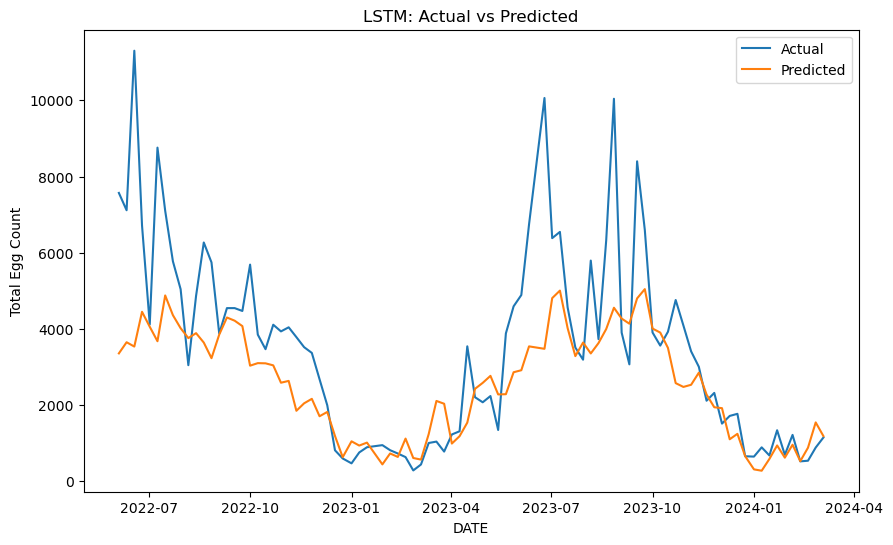

In [438]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='Actual')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()

# LSTM_2

In [283]:
df = young_df_weather.copy()
df.set_index(['觀測時間(day)'], inplace=True)
df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3', '陽性率%'])

In [284]:
train = df[0:120]
test = df[120:]

In [285]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [286]:
n = 2   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\1192628698.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/118 [00:00<?, ?it/s]

In [287]:
print(X[0])
print(y[0])

[[0.7        0.83728814 0.8034188  0.59574468 0.72916667 0.0877193
  1.         0.48241206 0.97222222 0.         0.         0.
  0.         0.57627119 0.66312434]
 [0.46129032 0.79322034 0.53561254 0.42198582 0.69791667 0.70175439
  1.         0.58291457 1.         0.         0.         0.
  0.         0.30508475 0.34750266]]
0.022858047827693607


In [288]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(118, 2, 15)
(118,)


In [289]:
n_steps = 2
n_features = 15
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [290]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 3ms/step - loss: 0.2004 - mse: 0.2004 - mape: 2240471.5000
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1612 - mse: 0.1612 - mape: 1836249.1250
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.1281 - mse: 0.1281 - mape: 1447764.7500
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0992 - mse: 0.0992 - mape: 1070934.6250
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0751 - mse: 0.0751 - mape: 688722.7500
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0554 - mse: 0.0554 - mape: 122086.0312
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0397 - mse: 0.0397 - mape: 246469.8906
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0287 - mse: 0.0287 - mape: 436398.8125
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0217 - mse: 0.0217 - mape: 

In [291]:
# 從 history 中提取 MSE
mse_history = history.history['mse']

# 將 MSE 轉換為 RMSE
rmse_history = np.sqrt(mse_history)

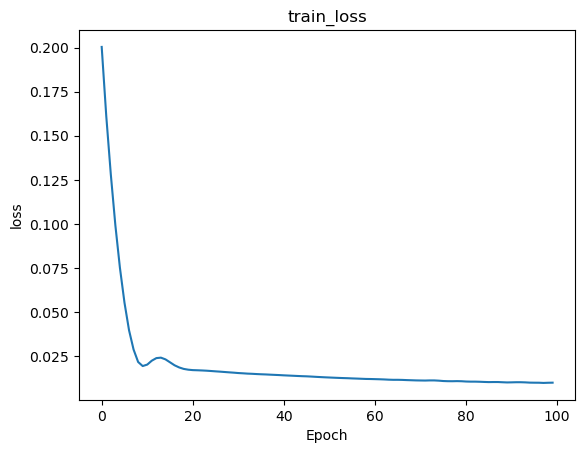

In [292]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [293]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [294]:
predicted_values

array([[ 0.30345255],
       [ 0.28445536],
       [ 0.2878821 ],
       [ 0.2400339 ],
       [ 0.32159027],
       [ 0.26547694],
       [ 0.24138667],
       [ 0.39498433],
       [ 0.30917573],
       [ 0.37237155],
       [ 0.2916873 ],
       [ 0.37124345],
       [ 0.3511172 ],
       [ 0.3780741 ],
       [ 0.3909262 ],
       [ 0.32349524],
       [ 0.34778056],
       [ 0.28547844],
       [ 0.28501454],
       [ 0.29956532],
       [ 0.26949936],
       [ 0.2524419 ],
       [ 0.23526348],
       [ 0.20951782],
       [ 0.12122689],
       [ 0.20633072],
       [ 0.20955573],
       [ 0.14840975],
       [ 0.13246188],
       [ 0.08701353],
       [ 0.0388488 ],
       [ 0.03636165],
       [ 0.06446578],
       [ 0.06178144],
       [ 0.04327652],
       [ 0.00231216],
       [ 0.03796651],
       [ 0.08144709],
       [ 0.03888087],
       [ 0.00621479],
       [ 0.04837351],
       [ 0.06352717],
       [ 0.07188489],
       [ 0.10030261],
       [ 0.16045676],
       [ 0

In [295]:
predicted_values.shape

(91, 1)

In [296]:
predicted_values = np.repeat(predicted_values, 16, axis=1)

In [297]:
predicted_values

array([[0.30345255, 0.30345255, 0.30345255, ..., 0.30345255, 0.30345255,
        0.30345255],
       [0.28445536, 0.28445536, 0.28445536, ..., 0.28445536, 0.28445536,
        0.28445536],
       [0.2878821 , 0.2878821 , 0.2878821 , ..., 0.2878821 , 0.2878821 ,
        0.2878821 ],
       ...,
       [0.0297868 , 0.0297868 , 0.0297868 , ..., 0.0297868 , 0.0297868 ,
        0.0297868 ],
       [0.1113632 , 0.1113632 , 0.1113632 , ..., 0.1113632 , 0.1113632 ,
        0.1113632 ],
       [0.05373975, 0.05373975, 0.05373975, ..., 0.05373975, 0.05373975,
        0.05373975]], dtype=float32)

In [298]:
predicted_values.shape

(91, 16)

In [299]:
predicted_values = scaler.inverse_transform(predicted_values)

In [300]:
#predicted_values  #已經還原成真實值

In [301]:
predicted_values.shape

(91, 16)

In [302]:
P_d = predicted_values.copy()

In [303]:
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])

In [304]:
new_df

,預測出的卵粒數
0,3627.440186
1,3418.129150
2,3455.884766
3,2928.693359
4,3827.281494
5,3209.024902
6,2943.598389
7,4635.937500
8,3690.498047
9,4386.789551


In [305]:
look_df = df.copy()

In [306]:
look_df = look_df.iloc[-91:]

In [307]:
last_34_rows = look_df.iloc[-91:]

In [308]:
last_34_rows.shape

(91, 16)

In [309]:
df_34_ = young_df_weather.copy()

In [310]:
df_34_ = df_34_[-91:]

In [311]:
df_34_ = df_34_[['觀測時間(day)','總卵粒數']]

In [312]:
df_34_reset_index = df_34_.reset_index(drop=True)

In [313]:
new_df = new_df.astype('float64')

In [314]:
merged_df = pd.concat([df_34_reset_index, new_df], axis=1)

In [315]:
merged_df

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-05-28,6842.0,3627.440186
1,2022-06-04,7569.0,3418.129150
2,2022-06-11,7114.0,3455.884766
3,2022-06-18,11302.0,2928.693359
4,2022-06-25,6711.0,3827.281494
5,2022-07-02,4117.0,3209.024902
6,2022-07-09,8758.0,2943.598389
7,2022-07-16,7100.0,4635.937500
8,2022-07-23,5774.0,3690.498047
9,2022-07-30,5041.0,4386.789551


In [316]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1944.0780396175708


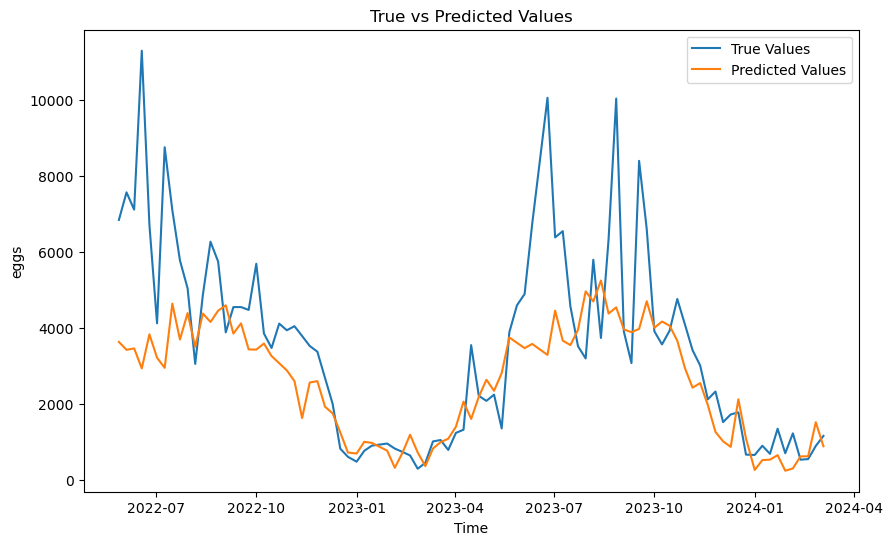

In [317]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='True Values')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('eggs')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# LSTM_3

In [252]:
df = young_df_weather.copy()
df.set_index(['觀測時間(day)'], inplace=True)
df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3', '陽性率%'])

In [253]:
train = df[0:120]
test = df[120:]

In [254]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [255]:
n = 5   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\394679992.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/115 [00:00<?, ?it/s]

In [256]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(115, 5, 15)
(115,)


In [257]:
n_steps = 5
n_features = 15
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [258]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 4ms/step - loss: 0.0249 - mse: 0.0249 - mape: 1487953.3750
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221 - mape: 1149459.3750
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0205 - mse: 0.0205 - mape: 1248815.0000
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0193 - mse: 0.0193 - mape: 1324215.8750
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0177 - mse: 0.0177 - mape: 1100924.2500
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0165 - mse: 0.0165 - mape: 976354.3125
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0164 - mse: 0.0164 - mape: 769542.0625
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0153 - mse: 0.0153 - mape: 766318.0625
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0144 - mse: 0.0144 - mape:

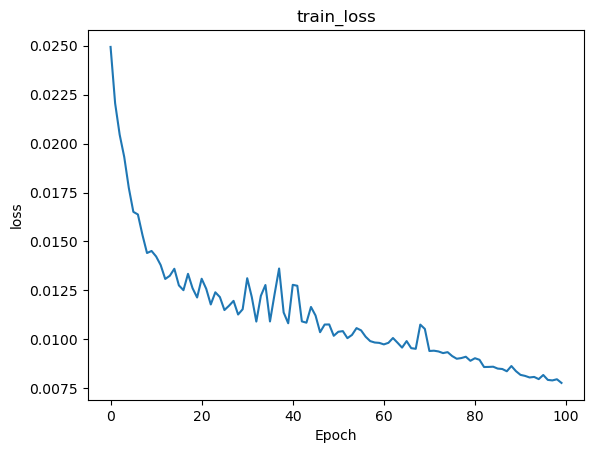

In [259]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [262]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)

In [263]:
X_test = np.array(X_test)

In [264]:
predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [265]:
predicted_values.shape

(88, 1)

In [266]:
predicted_values = np.repeat(predicted_values, 16, axis=1)

In [267]:
predicted_values.shape

(88, 16)

In [268]:
predicted_values = scaler.inverse_transform(predicted_values)
predicted_values.shape

(88, 16)

In [269]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
new_df

,預測出的卵粒數
0,3359.010498
1,4046.795898
2,4057.088135
3,3717.988281
4,3879.943604
5,3926.744629
6,3578.771973
7,3220.823975
8,4295.662598
9,4266.099121


In [271]:
look_df = df.copy()

In [272]:
look_df

,總卵粒數,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
觀測時間(day),,,,,,,,,,,,,,,,
2020-01-22,1910.0,21.7,1017.8,28.2,16.8,70.0,1.9,360,9.6,350.0,0.0,0.0,0.0,0.0,6.8,62.4
2020-01-29,3513.0,14.3,1016.5,18.8,11.9,67.0,5.4,360,11.6,360.0,0.0,0.0,0.0,0.0,3.6,32.7
2020-02-05,701.0,18.3,1018.0,25.1,14.4,73.0,4.0,360,9.0,360.0,0.0,0.0,0.0,0.0,9.2,82.7
2020-02-12,1398.0,0.0,1016.5,0.0,0.0,0.0,2.2,200,12.4,210.0,0.0,0.0,0.0,0.0,9.3,82.6
2020-02-19,1598.0,0.0,1022.6,0.0,0.0,0.0,2.6,350,8.1,350.0,0.0,0.0,0.0,0.0,10.0,87.7
2020-02-26,2171.0,24.1,1016.1,29.7,20.0,73.0,2.7,360,9.6,330.0,0.0,0.0,0.0,0.0,10.7,92.7
2020-03-04,4046.0,21.9,1015.4,27.0,16.7,73.0,4.4,360,12.3,360.0,0.0,0.1,0.0,0.0,2.6,22.3
2020-03-11,2684.0,20.3,1016.2,25.9,16.4,63.0,3.0,360,8.8,10.0,0.0,0.0,0.0,0.0,2.8,23.7
2020-03-18,2301.0,22.2,1014.4,26.7,18.9,70.0,1.7,130,6.5,320.0,0.0,0.0,0.0,0.0,2.8,23.4


In [273]:
look_df = look_df.iloc[-88:]

In [274]:
last_34_rows = look_df.iloc[-88:]

In [275]:
last_34_rows.shape

(88, 16)

In [276]:
df_34_ = young_df_weather.copy()
df_34_ = df_34_[-88:]
df_34_

,觀測時間(day),總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
128,2022-06-18,11302.0,7114.0,7569.0,6842.0,0.5407,30.2,1007.7,33.7,27.1,70.0,2.2,220,8.9,260.0,0.0,0.0,0.0,0.0,10.8,80.0
129,2022-06-25,6711.0,11302.0,7114.0,7569.0,0.4457,29.3,1007.7,33.6,26.0,73.0,3.7,150,12.8,210.0,18.0,0.9,7.0,17.5,5.4,40.0
130,2022-07-02,4117.0,6711.0,11302.0,7114.0,0.3256,27.7,1005.8,31.3,25.2,84.0,3.0,160,10.3,180.0,46.5,1.9,17.0,38.0,0.0,0.0
131,2022-07-09,8758.0,4117.0,6711.0,11302.0,0.4845,30.3,1005.7,34.1,26.8,74.0,2.3,220,8.0,220.0,0.0,0.0,0.0,0.0,10.1,75.2
132,2022-07-16,7100.0,8758.0,4117.0,6711.0,0.4205,28.9,1005.7,32.6,25.2,78.0,1.9,140,10.0,270.0,9.0,0.5,7.0,9.0,3.1,23.2
133,2022-07-23,5774.0,7100.0,8758.0,4117.0,0.3624,31.0,1008.0,34.5,28.2,71.0,2.3,280,7.7,300.0,0.0,0.0,0.0,0.0,12.0,90.5
134,2022-07-30,5041.0,5774.0,7100.0,8758.0,0.3566,29.4,1002.0,32.4,26.5,81.0,2.8,320,10.0,340.0,28.5,1.7,8.5,18.5,5.1,38.8
135,2022-08-06,3047.0,5041.0,5774.0,7100.0,0.2597,29.1,1007.0,33.4,27.0,81.0,1.7,40,8.9,280.0,7.5,1.0,3.0,7.0,5.7,43.3
136,2022-08-13,4865.0,3047.0,5041.0,5774.0,0.3605,28.9,1007.5,33.5,25.7,77.0,1.9,290,8.7,300.0,0.0,0.1,0.0,0.0,0.0,0.0
137,2022-08-20,6268.0,4865.0,3047.0,5041.0,0.4050,30.0,1008.8,34.0,26.9,72.0,2.5,260,8.9,260.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
df_34_ = df_34_[['觀測時間(day)','總卵粒數']]
df_34_reset_index = df_34_.reset_index(drop=True)

In [278]:
new_df = new_df.astype('float64')

In [279]:
merged_df = pd.concat([df_34_reset_index, new_df], axis=1)

In [280]:
merged_df

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-06-18,11302.0,3359.010498
1,2022-06-25,6711.0,4046.795898
2,2022-07-02,4117.0,4057.088135
3,2022-07-09,8758.0,3717.988281
4,2022-07-16,7100.0,3879.943604
5,2022-07-23,5774.0,3926.744629
6,2022-07-30,5041.0,3578.771973
7,2022-08-06,3047.0,3220.823975
8,2022-08-13,4865.0,4295.662598
9,2022-08-20,6268.0,4266.099121


In [281]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1818.2852732817857


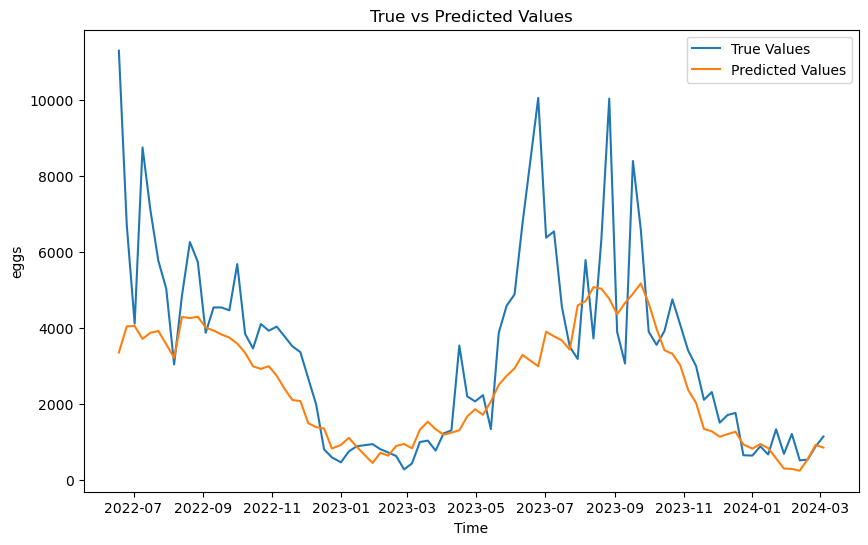

In [282]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='True Values')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('eggs')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# LSTM_3

In [318]:
df = young_df_weather.copy()
df.set_index(['觀測時間(day)'], inplace=True)
df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3', '陽性率%'])

In [319]:
train = df[0:120]
test = df[120:]

In [320]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [321]:
n = 1   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) 
    indexes.append(train.index[i+n]) 

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\602022940.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/119 [00:00<?, ?it/s]

In [322]:
X=np.array(X) 
y=np.array(y)
print(X.shape)
print(y.shape)

(119, 1, 15)
(119,)


In [323]:
n_steps = 1
n_features = 15
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [324]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 2ms/step - loss: 0.0846 - mse: 0.0846 - mape: 480875.6875
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0721 - mse: 0.0721 - mape: 164246.9688
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0616 - mse: 0.0616 - mape: 62353.2070
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0524 - mse: 0.0524 - mape: 232107.4531
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0444 - mse: 0.0444 - mape: 326573.0312
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0380 - mse: 0.0380 - mape: 515698.2500
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.0326 - mse: 0.0326 - mape: 705495.6250
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0288 - mse: 0.0288 - mape: 883812.3125
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0261 - mse: 0.0261 - mape: 10534

In [325]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)

X_test = np.array(X_test)
predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 998us/step


In [326]:
predicted_values.shape

(92, 1)

In [327]:
predicted_values = np.repeat(predicted_values, 16, axis=1)
predicted_values = scaler.inverse_transform(predicted_values)
predicted_values.shape

(92, 16)

In [328]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
new_df

,預測出的卵粒數
0,1975.062744
1,2767.108887
2,3370.320312
3,3172.182129
4,2398.047607
5,3543.475342
6,3318.438477
7,2709.170166
8,3699.037598
9,3484.784668


In [329]:
look_df = df.copy()
look_df = look_df.iloc[-92:]
last_34_rows = look_df.iloc[-92:]
last_34_rows.shape

(92, 16)

In [330]:
df_34_ = young_df_weather.copy()
df_34_ = df_34_[-92:]
df_34_

,觀測時間(day),總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
124,2022-05-21,5725.0,2665.0,3973.0,3098.0,0.3798,26.8,1006.4,31.0,24.0,79.0,2.4,340,8.6,250.0,0.0,0.0,0.0,0.0,8.6,64.7
125,2022-05-28,6842.0,5725.0,2665.0,3973.0,0.4380,29.1,1006.7,33.6,25.1,76.0,2.6,150,8.3,270.0,0.0,0.0,0.0,0.0,11.3,84.4
126,2022-06-04,7569.0,6842.0,5725.0,2665.0,0.4283,28.0,1007.5,31.6,25.9,84.0,2.9,140,10.4,240.0,12.0,0.8,4.0,4.0,4.4,32.7
127,2022-06-11,7114.0,7569.0,6842.0,5725.0,0.4574,28.2,1008.0,31.3,24.9,79.0,3.1,160,11.0,160.0,45.0,1.8,11.5,25.0,4.2,31.1
128,2022-06-18,11302.0,7114.0,7569.0,6842.0,0.5407,30.2,1007.7,33.7,27.1,70.0,2.2,220,8.9,260.0,0.0,0.0,0.0,0.0,10.8,80.0
129,2022-06-25,6711.0,11302.0,7114.0,7569.0,0.4457,29.3,1007.7,33.6,26.0,73.0,3.7,150,12.8,210.0,18.0,0.9,7.0,17.5,5.4,40.0
130,2022-07-02,4117.0,6711.0,11302.0,7114.0,0.3256,27.7,1005.8,31.3,25.2,84.0,3.0,160,10.3,180.0,46.5,1.9,17.0,38.0,0.0,0.0
131,2022-07-09,8758.0,4117.0,6711.0,11302.0,0.4845,30.3,1005.7,34.1,26.8,74.0,2.3,220,8.0,220.0,0.0,0.0,0.0,0.0,10.1,75.2
132,2022-07-16,7100.0,8758.0,4117.0,6711.0,0.4205,28.9,1005.7,32.6,25.2,78.0,1.9,140,10.0,270.0,9.0,0.5,7.0,9.0,3.1,23.2
133,2022-07-23,5774.0,7100.0,8758.0,4117.0,0.3624,31.0,1008.0,34.5,28.2,71.0,2.3,280,7.7,300.0,0.0,0.0,0.0,0.0,12.0,90.5


In [331]:
df_34_ = df_34_[['觀測時間(day)','總卵粒數']]
df_34_reset_index = df_34_.reset_index(drop=True)

In [332]:
merged_df = pd.concat([df_34_reset_index, new_df], axis=1)
merged_df

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-05-21,5725.0,1975.062744
1,2022-05-28,6842.0,2767.108887
2,2022-06-04,7569.0,3370.320312
3,2022-06-11,7114.0,3172.182129
4,2022-06-18,11302.0,2398.047607
5,2022-06-25,6711.0,3543.475342
6,2022-07-02,4117.0,3318.438477
7,2022-07-09,8758.0,2709.170166
8,2022-07-16,7100.0,3699.037598
9,2022-07-23,5774.0,3484.784668


In [333]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 2238.882953577506


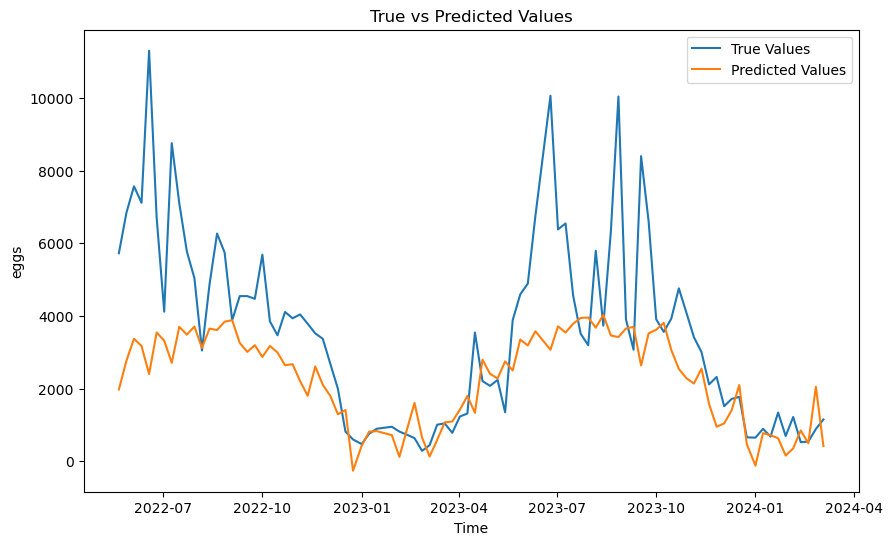

In [334]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='True Values')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('eggs')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# LSTM_new_feature

In [337]:
df = young_df_weather.copy()

In [338]:
df.set_index(['觀測時間(day)'], inplace=True)

df = df.drop(columns=['總卵粒數1', '總卵粒數2', '總卵粒數3'])

In [339]:
train = df[0:120]
test = df[120:]

In [345]:
train

,總卵粒數,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
0,0.086681,0.119954,0.700000,0.837288,0.803419,0.595745,0.729167,0.087719,1.000000,0.482412,0.972222,0.000000,0.000000,0.000000,0.000000,0.576271,0.663124
1,0.171303,0.192383,0.461290,0.793220,0.535613,0.421986,0.697917,0.701754,1.000000,0.582915,1.000000,0.000000,0.000000,0.000000,0.000000,0.305085,0.347503
2,0.022858,0.025228,0.590323,0.844068,0.715100,0.510638,0.760417,0.456140,1.000000,0.452261,1.000000,0.000000,0.000000,0.000000,0.000000,0.779661,0.878852
3,0.059653,0.078939,0.000000,0.793220,0.000000,0.000000,0.000000,0.140351,0.542857,0.623116,0.583333,0.000000,0.000000,0.000000,0.000000,0.788136,0.877790
4,0.070211,0.116699,0.000000,1.000000,0.000000,0.000000,0.000000,0.210526,0.971429,0.407035,0.972222,0.000000,0.000000,0.000000,0.000000,0.847458,0.931987
5,0.100459,0.135742,0.777419,0.779661,0.846154,0.709220,0.760417,0.228070,1.000000,0.482412,0.916667,0.000000,0.000000,0.000000,0.000000,0.906780,0.985122
6,0.199440,0.258626,0.706452,0.755932,0.769231,0.592199,0.760417,0.526316,1.000000,0.618090,1.000000,0.000000,0.008772,0.000000,0.000000,0.220339,0.236982
7,0.127541,0.192383,0.654839,0.783051,0.737892,0.581560,0.656250,0.280702,1.000000,0.442211,0.027778,0.000000,0.000000,0.000000,0.000000,0.237288,0.251860
8,0.107322,0.164062,0.716129,0.722034,0.760684,0.670213,0.729167,0.052632,0.342857,0.326633,0.888889,0.000000,0.000000,0.000000,0.000000,0.237288,0.248672
9,0.084517,0.141927,0.803226,0.657627,0.863248,0.765957,0.802083,0.175439,0.000000,0.366834,0.888889,0.000000,0.000000,0.000000,0.000000,0.610169,0.630181


In [340]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [341]:
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\567902423.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/117 [00:00<?, ?it/s]

In [342]:
print(X[0])
print(y[0])

[[0.11995443 0.7        0.83728814 0.8034188  0.59574468 0.72916667
  0.0877193  1.         0.48241206 0.97222222 0.         0.
  0.         0.         0.57627119 0.66312434]
 [0.19238281 0.46129032 0.79322034 0.53561254 0.42198582 0.69791667
  0.70175439 1.         0.58291457 1.         0.         0.
  0.         0.         0.30508475 0.34750266]
 [0.02522786 0.59032258 0.8440678  0.71509972 0.5106383  0.76041667
  0.45614035 1.         0.45226131 1.         0.         0.
  0.         0.         0.77966102 0.87885228]]
0.05965264213693713


In [348]:
n_steps = 3
n_features = 16
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [350]:
X = np.array(X)
y = np.array(y)

In [351]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 4ms/step - loss: 0.1097 - mse: 0.1097 - mape: 399145.9062
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0724 - mse: 0.0724 - mape: 217089.4375
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0468 - mse: 0.0468 - mape: 815329.3750
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0329 - mse: 0.0329 - mape: 1377094.8750
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0281 - mse: 0.0281 - mape: 2055733.5000
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0293 - mse: 0.0293 - mape: 2332995.7500
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0321 - mse: 0.0321 - mape: 2423403.5000
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0331 - mse: 0.0331 - mape: 2483344.5000
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0314 - mse: 0.0314 - mape:

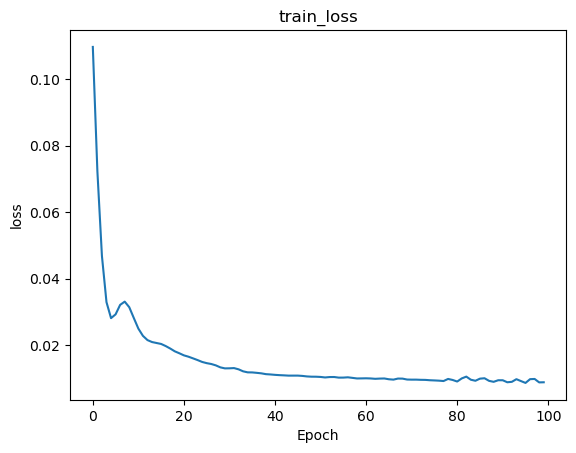

In [352]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [361]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [362]:
predicted_values

array([[ 3.45159024e-01],
       [ 3.11966836e-01],
       [ 2.97219843e-01],
       [ 3.98615032e-01],
       [ 3.73653471e-01],
       [ 2.79178739e-01],
       [ 4.03564692e-01],
       [ 3.68579626e-01],
       [ 3.46167713e-01],
       [ 3.07831377e-01],
       [ 3.13262343e-01],
       [ 3.29109758e-01],
       [ 3.06645244e-01],
       [ 3.34958881e-01],
       [ 3.18365723e-01],
       [ 3.31435174e-01],
       [ 3.45940828e-01],
       [ 2.65630603e-01],
       [ 2.64568090e-01],
       [ 2.21655875e-01],
       [ 2.18918949e-01],
       [ 2.07761303e-01],
       [ 2.15741932e-01],
       [ 1.63963661e-01],
       [ 1.70370549e-01],
       [ 1.69450402e-01],
       [ 1.45906806e-01],
       [ 1.45132393e-01],
       [ 1.02514587e-01],
       [ 2.87097357e-02],
       [ 3.64687704e-02],
       [ 8.06745887e-03],
       [ 2.89599374e-02],
       [ 1.05360486e-02],
       [ 3.43767516e-02],
       [ 4.55775447e-02],
       [ 6.93199113e-02],
       [ 5.09855710e-02],
       [ 2.9

In [363]:
predicted_values.shape

(90, 1)

In [364]:
predicted_values = np.repeat(predicted_values, 17, axis=1)

In [365]:
predicted_values.shape

(90, 17)

In [366]:
predicted_values = scaler.inverse_transform(predicted_values)

In [367]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
look_df = df.copy()
last_85_rows = look_df.iloc[-90:]
last_85_rows.shape

(90, 17)

In [368]:
df_85_ = young_df_weather.copy()

In [369]:
df_85_ = df_85_[-90:]
df_85_ = df_85_[['觀測時間(day)','總卵粒數']]
df_85_reset_index = df_85_.reset_index(drop=True)

In [370]:
new_df

,預測出的卵粒數
0,4086.962158
1,3721.250488
2,3558.768066
3,4675.940430
4,4400.914062
5,3359.991211
6,4730.475586
7,4345.010254
8,4098.075684
9,3675.686035


In [371]:
df_85_reset_index

,觀測時間(day),總卵粒數
0,2022-06-04,7569.0
1,2022-06-11,7114.0
2,2022-06-18,11302.0
3,2022-06-25,6711.0
4,2022-07-02,4117.0
5,2022-07-09,8758.0
6,2022-07-16,7100.0
7,2022-07-23,5774.0
8,2022-07-30,5041.0
9,2022-08-06,3047.0


In [372]:
new_df = new_df.astype('float64')
merged_df = pd.concat([df_85_reset_index, new_df], axis=1)
merged_df 

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-06-04,7569.0,4086.962158
1,2022-06-11,7114.0,3721.250488
2,2022-06-18,11302.0,3558.768066
3,2022-06-25,6711.0,4675.940430
4,2022-07-02,4117.0,4400.914062
5,2022-07-09,8758.0,3359.991211
6,2022-07-16,7100.0,4730.475586
7,2022-07-23,5774.0,4345.010254
8,2022-07-30,5041.0,4098.075684
9,2022-08-06,3047.0,3675.686035


In [373]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1875.2845700882099


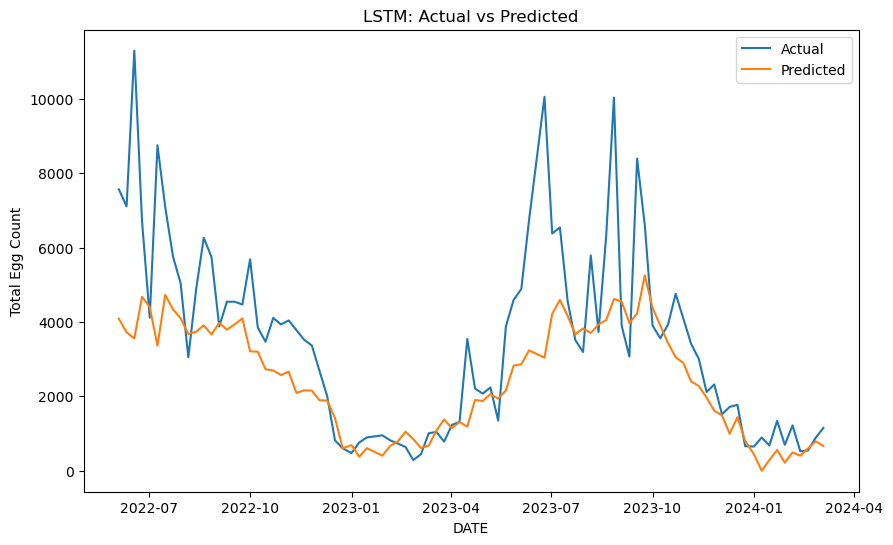

In [374]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='Actual')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()

# 嘗試刪掉其他feature

In [375]:
df = young_df_weather.copy()

In [376]:
df

,觀測時間(day),總卵粒數,總卵粒數1,總卵粒數2,總卵粒數3,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
3,2020-01-22,1910.0,2775.0,2543.0,2060.0,0.1105,21.7,1017.8,28.2,16.8,70.0,1.9,360,9.6,350.0,0.0,0.0,0.0,0.0,6.8,62.4
4,2020-01-29,3513.0,1910.0,2775.0,2543.0,0.1550,14.3,1016.5,18.8,11.9,67.0,5.4,360,11.6,360.0,0.0,0.0,0.0,0.0,3.6,32.7
5,2020-02-05,701.0,3513.0,1910.0,2775.0,0.0523,18.3,1018.0,25.1,14.4,73.0,4.0,360,9.0,360.0,0.0,0.0,0.0,0.0,9.2,82.7
6,2020-02-12,1398.0,701.0,3513.0,1910.0,0.0853,0.0,1016.5,0.0,0.0,0.0,2.2,200,12.4,210.0,0.0,0.0,0.0,0.0,9.3,82.6
7,2020-02-19,1598.0,1398.0,701.0,3513.0,0.1085,0.0,1022.6,0.0,0.0,0.0,2.6,350,8.1,350.0,0.0,0.0,0.0,0.0,10.0,87.7
8,2020-02-26,2171.0,1598.0,1398.0,701.0,0.1202,24.1,1016.1,29.7,20.0,73.0,2.7,360,9.6,330.0,0.0,0.0,0.0,0.0,10.7,92.7
9,2020-03-04,4046.0,2171.0,1598.0,1398.0,0.1957,21.9,1015.4,27.0,16.7,73.0,4.4,360,12.3,360.0,0.0,0.1,0.0,0.0,2.6,22.3
10,2020-03-11,2684.0,4046.0,2171.0,1598.0,0.1550,20.3,1016.2,25.9,16.4,63.0,3.0,360,8.8,10.0,0.0,0.0,0.0,0.0,2.8,23.7
11,2020-03-18,2301.0,2684.0,4046.0,2171.0,0.1376,22.2,1014.4,26.7,18.9,70.0,1.7,130,6.5,320.0,0.0,0.0,0.0,0.0,2.8,23.4
12,2020-03-25,1869.0,2301.0,2684.0,4046.0,0.1240,24.9,1012.5,30.3,21.6,77.0,2.4,10,7.3,320.0,0.0,0.0,0.0,0.0,7.2,59.3


In [377]:
df.set_index(['觀測時間(day)'], inplace=True)

df = df.drop(columns=['總卵粒數1'])

In [378]:
train = df[0:120]
test = df[120:]

In [379]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [380]:
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\567902423.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/117 [00:00<?, ?it/s]

In [381]:
print(X[0])
print(y[0])

[[0.12009713 0.09459959 0.11995443 0.7        0.83728814 0.8034188
  0.59574468 0.72916667 0.0877193  1.         0.48241206 0.97222222
  0.         0.         0.         0.         0.57627119 0.66312434]
 [0.1323444  0.12009713 0.19238281 0.46129032 0.79322034 0.53561254
  0.42198582 0.69791667 0.70175439 1.         0.58291457 1.
  0.         0.         0.         0.         0.30508475 0.34750266]
 [0.0866811  0.1323444  0.02522786 0.59032258 0.8440678  0.71509972
  0.5106383  0.76041667 0.45614035 1.         0.45226131 1.
  0.         0.         0.         0.         0.77966102 0.87885228]]
0.05965264213693713


In [382]:
X = np.array(X)
y = np.array(y)

In [383]:
n_steps = 3
n_features = 18
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [384]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 3ms/step - loss: 0.0305 - mse: 0.0305 - mape: 920036.6250
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0220 - mse: 0.0220 - mape: 1478462.5000
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0244 - mse: 0.0244 - mape: 1845510.7500
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0238 - mse: 0.0238 - mape: 1841839.7500
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0205 - mse: 0.0205 - mape: 1458275.7500
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0180 - mse: 0.0180 - mape: 1216698.5000
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - mape: 1105514.2500
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163 - mape: 923686.4375
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157 - mape

In [385]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [387]:
predicted_values.shape

(90, 1)

In [388]:
look_df = df.copy()
last_85_rows = look_df.iloc[-90:]
last_85_rows.shape

(90, 19)

In [389]:
predicted_values = np.repeat(predicted_values, 19, axis=1)
predicted_values.shape

(90, 19)

In [390]:
predicted_values = scaler.inverse_transform(predicted_values)
predicted_values

array([[3.9186428e+03, 3.9186428e+03, 3.9186428e+03, ..., 1.2535526e+01,
        3.9585872e+00, 3.1041922e+01],
       [3.8866438e+03, 3.8866438e+03, 3.8866438e+03, ..., 1.2425165e+01,
        3.9237363e+00, 3.0768633e+01],
       [2.9031919e+03, 2.9031919e+03, 2.9031919e+03, ..., 9.0333357e+00,
        2.8526323e+00, 2.2369392e+01],
       ...,
       [1.2922948e+03, 1.2922948e+03, 1.2922948e+03, ..., 3.4775095e+00,
        1.0981610e+00, 8.6114120e+00],
       [1.5146613e+03, 1.5146613e+03, 1.5146613e+03, ..., 4.2444301e+00,
        1.3403463e+00, 1.0510550e+01],
       [1.4658658e+03, 1.4658658e+03, 1.4658658e+03, ..., 4.0761390e+00,
        1.2872019e+00, 1.0093808e+01]], dtype=float32)

In [391]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
new_df

,預測出的卵粒數
0,3918.642822
1,3886.643799
2,2903.191895
3,4077.000977
4,3305.470947
5,1923.478638
6,3885.442627
7,3527.486328
8,3775.337646
9,3141.307129


In [392]:
last_85_rows

,總卵粒數,總卵粒數2,總卵粒數3,陽性率%,氣溫(℃),測站氣壓(hPa),最高氣溫(℃),最低氣溫(℃),相對溼度(%),風速(m/s),風向(360degree),最大瞬間風(m/s),最大瞬間風風向(360degree),降水量(mm),降水時數(hour),最大十分鐘降水量(mm),最大六十分鐘降水量(mm),日照時數(hour),日照率(%)
觀測時間(day),,,,,,,,,,,,,,,,,,,
2022-06-04,7569.0,5725.0,2665.0,0.4283,28.0,1007.5,31.6,25.9,84.0,2.9,140,10.4,240.0,12.0,0.8,4.0,4.0,4.4,32.7
2022-06-11,7114.0,6842.0,5725.0,0.4574,28.2,1008.0,31.3,24.9,79.0,3.1,160,11.0,160.0,45.0,1.8,11.5,25.0,4.2,31.1
2022-06-18,11302.0,7569.0,6842.0,0.5407,30.2,1007.7,33.7,27.1,70.0,2.2,220,8.9,260.0,0.0,0.0,0.0,0.0,10.8,80.0
2022-06-25,6711.0,7114.0,7569.0,0.4457,29.3,1007.7,33.6,26.0,73.0,3.7,150,12.8,210.0,18.0,0.9,7.0,17.5,5.4,40.0
2022-07-02,4117.0,11302.0,7114.0,0.3256,27.7,1005.8,31.3,25.2,84.0,3.0,160,10.3,180.0,46.5,1.9,17.0,38.0,0.0,0.0
2022-07-09,8758.0,6711.0,11302.0,0.4845,30.3,1005.7,34.1,26.8,74.0,2.3,220,8.0,220.0,0.0,0.0,0.0,0.0,10.1,75.2
2022-07-16,7100.0,4117.0,6711.0,0.4205,28.9,1005.7,32.6,25.2,78.0,1.9,140,10.0,270.0,9.0,0.5,7.0,9.0,3.1,23.2
2022-07-23,5774.0,8758.0,4117.0,0.3624,31.0,1008.0,34.5,28.2,71.0,2.3,280,7.7,300.0,0.0,0.0,0.0,0.0,12.0,90.5
2022-07-30,5041.0,7100.0,8758.0,0.3566,29.4,1002.0,32.4,26.5,81.0,2.8,320,10.0,340.0,28.5,1.7,8.5,18.5,5.1,38.8


In [393]:
df_85_ = young_df_weather.copy()
df_85_ = df_85_[-90:]
df_85_ = df_85_[['觀測時間(day)','總卵粒數']]
df_85_reset_index = df_85_.reset_index(drop=True)
new_df

,預測出的卵粒數
0,3918.642822
1,3886.643799
2,2903.191895
3,4077.000977
4,3305.470947
5,1923.478638
6,3885.442627
7,3527.486328
8,3775.337646
9,3141.307129


In [394]:
df_85_reset_index

,觀測時間(day),總卵粒數
0,2022-06-04,7569.0
1,2022-06-11,7114.0
2,2022-06-18,11302.0
3,2022-06-25,6711.0
4,2022-07-02,4117.0
5,2022-07-09,8758.0
6,2022-07-16,7100.0
7,2022-07-23,5774.0
8,2022-07-30,5041.0
9,2022-08-06,3047.0


In [395]:
new_df = new_df.astype('float64')

In [396]:
merged_df = pd.concat([df_85_reset_index, new_df], axis=1)
merged_df 

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-06-04,7569.0,3918.642822
1,2022-06-11,7114.0,3886.643799
2,2022-06-18,11302.0,2903.191895
3,2022-06-25,6711.0,4077.000977
4,2022-07-02,4117.0,3305.470947
5,2022-07-09,8758.0,1923.478638
6,2022-07-16,7100.0,3885.442627
7,2022-07-23,5774.0,3527.486328
8,2022-07-30,5041.0,3775.337646
9,2022-08-06,3047.0,3141.307129


In [397]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 2015.2458940358497


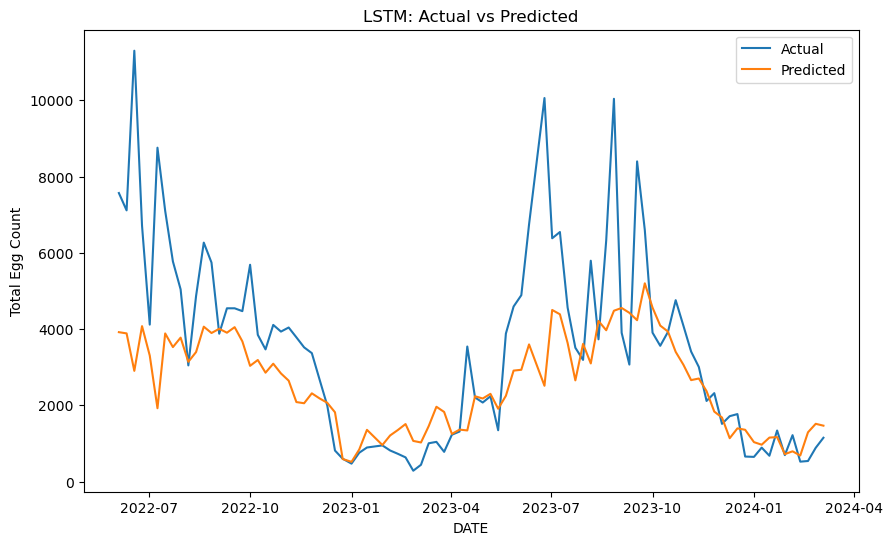

In [398]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='Actual')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('Total Egg Count')
plt.legend()
plt.show()

# 換時間(7:3)

In [460]:
df = young_df_weather.copy()

In [461]:
df.set_index(['觀測時間(day)'], inplace=True)

df = df.drop(columns=['陽性率%']) #n = 18

In [462]:
train = df[0:99]
test = df[99:]

In [463]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [464]:
n = 3   #LSTM 處理的時間步
feature_names = list(train.drop('總卵粒數', axis=1).columns)

X = []
y = []
indexes = []

norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
    X.append(norm_data_x.iloc[i:i+n].values) 
    y.append(train['總卵粒數'].iloc[i+n]) #現有資料+3天的Y
    indexes.append(train.index[i+n]) #Y的日期

C:\Users\lilj\AppData\Local\Temp\ipykernel_18692\567902423.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0,len(train)-n)):


  0%|          | 0/96 [00:00<?, ?it/s]

In [465]:
X = np.array(X)
y = np.array(y)

In [466]:
n_steps = 3
n_features = 18
model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
#return_sequences預設false，輸出是否為序列? 是: 輸出多個值
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

In [470]:
history = model.fit(X,y,batch_size=100,epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 6ms/step - loss: 0.0094 - mse: 0.0094 - mape: 222374.1406
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093 - mape: 220091.7969
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0092 - mse: 0.0092 - mape: 233656.3594
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0092 - mse: 0.0092 - mape: 232149.1719
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0091 - mse: 0.0091 - mape: 221422.1250
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090 - mape: 210733.1094
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0089 - mse: 0.0089 - mape: 207888.9531
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0089 - mse: 0.0089 - mape: 207835.3594
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088 - mape: 2035

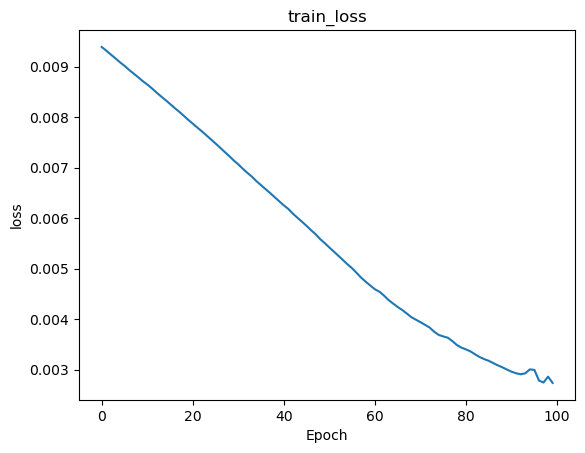

In [471]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [482]:
X_test = []
norm_data_x_test = test[feature_names]
for i in range(0, len(test) - n):
    X_test.append(norm_data_x_test.iloc[i:i+n].values)
    
X_test = np.array(X_test)

predicted_values = model.predict(X_test)

4/4 [==============================] - 0s 976us/step


In [483]:
predicted_values.shape

(111, 1)

In [484]:
predicted_values = np.repeat(predicted_values, 19, axis=1)
predicted_values.shape

(111, 19)

In [485]:
predicted_values = scaler.inverse_transform(predicted_values)
predicted_values

array([[1.7292716e+03, 1.7292716e+03, 1.7292716e+03, ..., 4.9846001e+00,
        1.5740843e+00, 1.2343444e+01],
       [1.5763591e+03, 1.5763591e+03, 1.5763591e+03, ..., 4.4572201e+00,
        1.4075432e+00, 1.1037484e+01],
       [2.0830012e+03, 2.0830012e+03, 2.0830012e+03, ..., 6.2045789e+00,
        1.9593406e+00, 1.5364496e+01],
       ...,
       [1.3960111e+03, 1.3960111e+03, 1.3960111e+03, ..., 3.8352172e+00,
        1.2111213e+00, 9.4972095e+00],
       [1.5784178e+03, 1.5784178e+03, 1.5784178e+03, ..., 4.4643202e+00,
        1.4097853e+00, 1.1055067e+01],
       [1.1882452e+03, 1.1882452e+03, 1.1882452e+03, ..., 3.1186528e+00,
        9.8483777e-01, 7.7227697e+00]], dtype=float32)

In [486]:
P_d = predicted_values.copy()
new_df = pd.DataFrame(P_d[:, 0], columns=['預測出的卵粒數'])
new_df

,預測出的卵粒數
0,1729.271606
1,1576.359131
2,2083.001221
3,3079.504883
4,2624.507812
5,2187.321533
6,1889.878662
7,1048.635620
8,1770.973267
9,1546.929077


In [487]:
look_df = df.copy()

In [488]:
last_85_rows = look_df.iloc[-111:]
last_85_rows.shape

(111, 19)

In [489]:
df_85_ = young_df_weather.copy()
df_85_ = df_85_[-111:]
df_85_ = df_85_[['觀測時間(day)','總卵粒數']]
df_85_reset_index = df_85_.reset_index(drop=True)
df_85_reset_index

,觀測時間(day),總卵粒數
0,2022-01-01,1520.0
1,2022-01-08,1126.0
2,2022-01-15,565.0
3,2022-01-22,779.0
4,2022-02-05,1092.0
5,2022-02-12,932.0
6,2022-02-19,534.0
7,2022-02-26,1195.0
8,2022-03-05,1965.0
9,2022-03-12,2892.0


In [490]:
new_df = new_df.astype('float64')
merged_df = pd.concat([df_85_reset_index, new_df], axis=1)
merged_df 

,觀測時間(day),總卵粒數,預測出的卵粒數
0,2022-01-01,1520.0,1729.271606
1,2022-01-08,1126.0,1576.359131
2,2022-01-15,565.0,2083.001221
3,2022-01-22,779.0,3079.504883
4,2022-02-05,1092.0,2624.507812
5,2022-02-12,932.0,2187.321533
6,2022-02-19,534.0,1889.878662
7,2022-02-26,1195.0,1048.635620
8,2022-03-05,1965.0,1770.973267
9,2022-03-12,2892.0,1546.929077


In [491]:
# 提取實際值和預測值
actual_values = merged_df['總卵粒數']
predicted_values = merged_df['預測出的卵粒數']

# 計算均方根誤差（RMSE）
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("RMSE:", rmse)

RMSE: 1982.789014017778


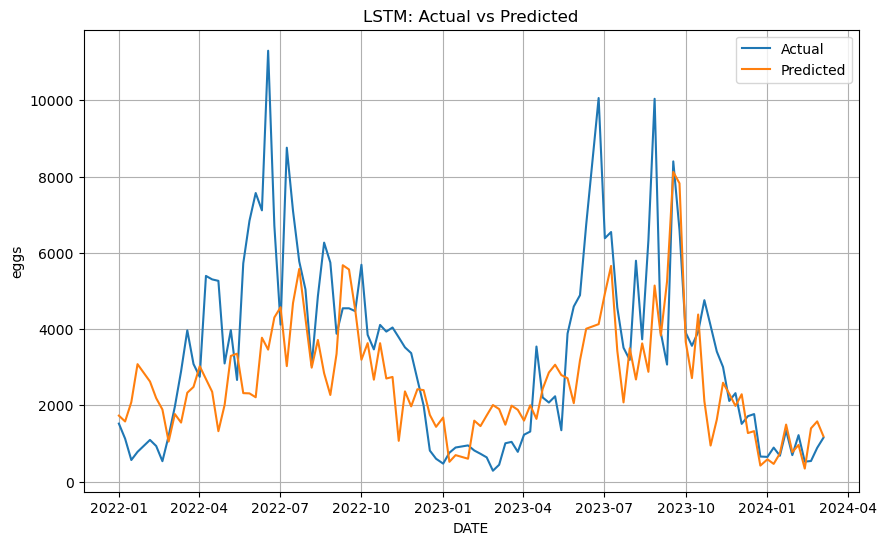

In [494]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['觀測時間(day)'], merged_df['總卵粒數'], label='Actual')
plt.plot(merged_df['觀測時間(day)'], merged_df['預測出的卵粒數'], label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('DATE')
plt.ylabel('eggs')
plt.legend()
plt.grid(True)
plt.show()
